In [3]:
%gui qt
%matplotlib inline
from PIL import Image
from csbdeep.utils import Path, normalize
from glob import glob
from importlib import reload 
from magicgui import magicgui
from magicgui.widgets import Label, SpinBox, PushButton, Text, Container
from manager.acquisition import acq, acq_stim, acq_multi, acq_multi_dark, acq_mask
from manager.dmd import dmd
from manager.fov import FOV
from manager.preset import preset
from manager.stage import load_pos_file, get_pos_from_mm, stage_position
from matplotlib import pyplot as plt 
from multiprocessing import Process
from napari.layers import Image, Labels
from napari.qt import thread_worker
from pipeline.pipeline_single_frame import add_frame
from pipeline.stimulation import stim_random
from pycromanager import Acquisition, multi_d_acquisition_events
from pycromanager import Bridge
from addons.semantic_segmentation import init_VGG16_pyramid, fd_VGG16_pyramid
from skimage import io
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.morphology import square
from skimage.segmentation import expand_labels
from sklearn.ensemble import RandomForestClassifier
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois
from stardist.models import StarDist2D
from tqdm import tqdm
from addons.utils import create_folders
import cv2
import gc
import glob
import importlib.util
import math
import matplotlib
import matplotlib.pyplot as plt
import napari
import nest_asyncio
import numpy as np
import os
import pandas as pd
import pickle as pkl
import queue
import scipy
import skimage
import threading
import time
import random
import trackpy as tp
matplotlib.rcParams["image.interpolation"] = None
nest_asyncio.apply()

ModuleNotFoundError: No module named 'addons.utils'

## Setup connection with micro manager

In [2]:
bridge = Bridge() #connection to micro-manager
core = bridge.get_core()
studio = bridge.get_studio()
print(bridge.get_core())
dmd = dmd(core) #init dmd device

violet 395  1 ao25 
blue   440  2 ao24 
cyan   470  3 ao22 
teal   508  7 ao12 
green  555 10 ao26 (not in NIS)
red    640 14 ao11 (not in NIS)


In [3]:
nidaq_setup = preset(core) #focus preset
nidaq_setup.settings = [

    ["Spectra RIGHT","Teal_Level",100],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Level",100],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Level",100],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Level",100],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Level",100],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Level",100],
    ["Spectra RIGHT","Red_Enable",0],

    ["Spectra RIGHT","White_Enable",0],
    ['Andor sCMOS LEFT','AuxiliaryOutSource (TTL I/O)','FireAny']
]
nidaq_setup.apply_no_retry()

camera_setup = preset(core) #focus preset
camera_setup.settings = [
    ["Andor sCMOS LEFT","Binning",'2x2'],
    #["Andor sCMOS LEFT","Sensitivity/DynamicRange",'12-bit (low noise)'],
    #["Andor sCMOS LEFT","Exposure",'300'],
    #["Andor sCMOS LEFT","TriggerMode",'Software (Recommended for Live Mode)'],
    ["TILightPath","State",'2'],
    ["Mosaic3","TriggerMode",'InternalExpose'], #InternalSoftware
    #["Andor sCMOS LEFT","PixelReadoutRate",'200 MHz - lowest noise'],
]

camera_setup.apply(core)

Andor sCMOS LEFT: Set Binning to 2x2
TILightPath: Set State to 2
Mosaic3: Set TriggerMode to InternalExpose


In [4]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.apply()

## Create channel presets
#### Labels for state devices in micro-manager:
TIFilterBlock1  
0: empty  
1: 86000v2 - Sedat Quad  
2: 59222 - GFP/mCherry - ET  
3: 69308 - CFP/YFP/mCherry - ET  
4: 470lp  
5: zt 442/514/561  

Wheel-C:  
0: empty  
1: 84000v2 - DAPI/FITC/TRITC/Cy5 (Em1)  
2: 59022 - GFP/mCherry - ET (Em)  
3: CFP 458-482 (Ex)  
4: YFP 520-550 (Ex)  
5: CFP 460-500 (Ex)  
6-9: empty  

Spectra Colors:  
Blue (440), Cyan (bright blue 470), Green (yellow), Red, Teal (green/blue 508), Violet (359), White

In [5]:
mCherry = preset(core)
# 555/25 with same filterwheel as H2B or 575 with 2/2
mCherry.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "2"],#2 
    ["Wheel-C", "State", 2],# could also use 1 # standard  2
    ["Spectra RIGHT","Green_Enable",1],
    ["Spectra RIGHT","Green_Level",20] #25
]
mCherry.camera_exposure_time = 400 #150
mCherry.dmd_exposure_time = 100
mCherry.name = "mCherry / ERK-KTR"

mCherry.apply(core)
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 2
Wheel-C: Set State to 2
Spectra RIGHT: Set Green_Enable to 1
Spectra RIGHT: Set Green_Level to 20


In [6]:
miRFP = preset(core)
miRFP.settings = [
    ["TIFilterBlock1", "State", "1"],
    ["Wheel-C", "State", 1],
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],

    ["Spectra RIGHT","Red_Enable",1],
    ["Spectra RIGHT","Red_Level",100]
]
miRFP.camera_exposure_time = 500
miRFP.dmd_exposure_time = 150
miRFP.name = "miRFP"
miRFP.apply()
dmd.all_on()

In [7]:
OPTO_cal = preset(core) #mCitrine
OPTO_cal.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],

    ["TIFilterBlock1", "State", "1"],#2
    ["Wheel-C", "State", 0],#4 #1
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",1], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Cyan_Level",40]
]
OPTO_cal.camera_exposure_time = 400 #100ms for 40x 
OPTO_cal.dmd_exposure_time = 100
OPTO_cal.name = "OPTO_cal"
OPTO_cal.apply(core)
dmd.checker_board()

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 40


In [8]:
#CHECK EXPRESSION OF OPTOGENETIC CONSTRUCT
OPTO_capture = preset(core) #mCitrine
OPTO_capture.settings = [
    ["Spectra RIGHT","Teal_Enable",1],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["TIFilterBlock1", "State", "5"],#2
    ["Wheel-C", "State", 4],#4 #1 #2
    ["Spectra RIGHT","White_Level",0],
    ["Spectra RIGHT","Cyan_Enable",0], #should be cyan instead of TEAL which worked tho [green, ti=3, cw=1 \\ cyan ti=2,cw=1]
    ["Spectra RIGHT","Teal_Level",100]
]
OPTO_capture.camera_exposure_time = 2000 #100ms for 40x 
OPTO_capture.dmd_exposure_time = 2000
OPTO_capture.name = "514-zt mCitrine"
OPTO_capture.apply(core)
#dmd.checker_board()
dmd.all_on()

Spectra RIGHT: Set Teal_Enable to 1
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 5
Wheel-C: Set State to 4
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 0
Spectra RIGHT: Set Teal_Level to 100


In [9]:
black = preset(core)
black.settings = [
    ["Spectra RIGHT","Teal_Enable",0],
    ["Spectra RIGHT","Cyan_Enable",0],
    ["Spectra RIGHT","Violet_Enable",0],
    ["Spectra RIGHT","Green_Enable",0],
    ["Spectra RIGHT","Blue_Enable",0],
    ["Spectra RIGHT","Red_Enable",0],
    ["Wheel-C", "State", 0],
]
black.apply()

# NAPARI LIVEVIEW

In [12]:
#channels = [H2B_capture, ERK_capture, OPTO_capture]#OPTO_stim  , OPTO_cal OPTO_capture
channels = [miRFP,mCherry,OPTO_cal,OPTO_capture]

In [13]:
position_list = []

In [14]:
# data acquired on microscope or simulated?
simulate = False
clip =[1024, 1024]
# um / px, for correct scaling in napari
size_um = [0.16, 0.16]
#Time between checking again if new image is available
sleep_time = 0.05
# contrast limits for display
clim = [0, 300]
# initialize global variables
# flag to break while loops
acq_running = False
# empty queue for image data\ and z positions
img_queue = queue.Queue()
# xyz data stack
data = np.random.rand(clip[0], clip[1]) * clim[1]
zmq_lock = threading.Lock()
position_list = []

In [15]:
import cv2
font = cv2.FONT_HERSHEY_DUPLEX
checker_board = np.kron([[1, 0] * 20, [0, 1] * 20] * 20, np.ones((20, 20))) #https://stackoverflow.com/a/37440123
startup_screen = checker_board*100
cv2.putText(startup_screen,'github.com/hinderling',(40,780), font, 2,(255),2)
#plt.imshow(startup_screen)
data = startup_screen

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    zmq_lock.release()
    if remaining_image_count < 1:
        print('No image in uManager queue.')
        time.sleep(0.5)
        return
    
    zmq_lock.acquire()
    array = core.get_last_image()
    #core.clear_circular_buffer()
    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[:,:]
    img_queue.put([channels[1], img])
    return

def acquire_data_single_frames():
    global zmq_lock
    zmq_lock.acquire()
    image = acq(core)
    zmq_lock.release()
    
    #print('run grab_image')
    place_data(image)
    
def acquire_data():
    global channels
    global img_queue

    #array = live_manager.snap(False)
    zmq_lock.acquire()
    remaining_image_count = core.get_remaining_image_count()
    if remaining_image_count < 1:
        zmq_lock.release()
        #print('Warning: No image in uManager queue.')
        time.sleep(0.5)
        return
    try:
        array = core.get_last_image()
    except:
        print('ERROR: No image in uManager queue.')
        time.sleep(0.5)
        return

    zmq_lock.release()
    img_width = int(math.sqrt(len(array)))
    img = np.reshape(array, (img_width,img_width))
    img = img[::,::] #LUCIEN CHANGED IT DROM ::2
    img_queue.put([channels[1], img])
    return

def display_napari(image):
    """ Unpacks z position and reshapes image from pos_img. Writes image into correct
        slice of data, and updates napari display.
        Called by worker thread yielding elements from queue.
        Needs to be in code before worker thread connecting to it.
        Inputs: array pos_img: queue element containing z position and raveled image data.
        Global variables: np.array data: contains image stack
            img_queue: needed only to send task_done() signal.
    """
    global data
    global img_queue
    channel = image[0]
    image= image[1]
    layers[0].data = image
    img_queue.task_done()

@thread_worker
def append_img(img_queue):
    """ Worker thread that adds images to a list.
        Calls either micro-manager data acquisition or functions for simulating data.
        Inputs: img_queue """

    # start microscope data acquisition
    print('Worker started: append_img')
    if not simulate:
         while acq_running:
            acquire_data()
            time.sleep(sleep_time)

    # run with simulated data
    else:
        ii = 0
        while acq_running:
            simulate_data(ii)
            ii = ii + 1
            time.sleep(sleep_time)


@thread_worker(connect={'yielded': display_napari})
def yield_img(img_queue):
    """ Worker thread that checks whether there are elements in the
        queue, reads them out.
        Connected to display_napari function to update display """
    global acq_running
    
    #time_last_frame = time.time()
    #print('yield image')
    
    #print(acq_running)
    while acq_running:
        #time.sleep(sleep_time)
        # get elements from queue while there is more than one element
        # playing it safe: I'm always leaving one element in the queue
        img_queue_size = img_queue.qsize()
        #print(img_queue_size)
        while img_queue.qsize() > 0:
            #print("reading from queue ", img_queue.qsize())
            yield img_queue.get(block = False)
            #time_this_frame = time.time()
            #time_diff = time_this_frame - time_last_frame
            #fps = int(1/time_diff)
        time.sleep(sleep_time)

    # read out last remaining elements after end of acquisition
    while img_queue.qsize() > 0:
        yield img_queue.get(block = False)
@magicgui(call_button = "Start")
def start_acq():
    """ Called when Start button in pressed. Starts workers and resets global variables"""
    global acq_running
    global channels
    global zmq_lock
    if not acq_running:
        #z_range[3] = 0
        acq_running = True
        zmq_lock.acquire()
        core.start_continuous_sequence_acquisition(0)
        zmq_lock.release()
        worker1 = append_img(img_queue)
        worker2 = yield_img(img_queue)
        worker1.start()
        #worker2.start() # doesn't need to be started bc yield is connected
    else:
        print("acquisition already running!")

threshold = 100

@magicgui(slider_float={"widget_type": "FloatSlider", 'max': 1000})
def set_treshold(slider_float=100):
    global threshold
    threshold = slider_float

@magicgui(call_button = "Stop")
def stop_acq():
    # set global acq_running to False to stop other workers
    global acq_running
    global core
    global zmq_lock
    
    zmq_lock.acquire()
    core.stop_sequence_acquisition()    
    zmq_lock.release()
    acq_running = False

    
#a channel is a preset that has EXPOSURE and POWER function
channels_widget = Container()
channels_widgets_list = []
for channel in channels:
    @magicgui(
    call_button = 'SELECT',
    auto_call=False,
    label = {"widget_type": "Label","name":"label","label":channel.name},
    power={"widget_type": "SpinBox","name":"power" ,"label":'%',"min":0,"max": 100},
    exposure={"widget_type": "SpinBox","name":"ms" ,"label":'ms',"min":1,"max": 10000},
    #mode={"choices": ["reflect", "constant", "nearest", "mirror", "wrap"]},
    layout='horizontal',
    channel={'bind': channel} #replace this with channel 
    )
    def channel(label, power: int = channel.settings[-1][2], exposure=channel.camera_exposure_time, channel = channel):
        global channels
        #print(channel.name)
        stop_acq()
        channel.camera_exposure_time = exposure
        channel.set_power(power)
        zmq_lock.acquire()
        channel.apply()
        dmd.all_on()
        zmq_lock.release()
        start_acq()
    channels_widgets_list.append(channel)

channels_widget = Container(widgets=(channels_widgets_list))
        
@magicgui(call_button = "Store position")
def store_pos():
    global channels
    global zmq_lock
    global acq_running
    global position_list
    restart = False
    if acq_running:
        stop_acq()
        restart = True
    zmq_lock.acquire()
    point = core.get_xy_stage_position()
    pfs_offset = core.get_auto_focus_offset()
    x = point.get_x()
    y = point.get_y()
    zmq_lock.release()
    position_list.append(stage_position(x,y,pfs_offset))
    if restart:
        start_acq()    
        
# check if viewer is already open
# if yes: close and reopen
try:
    if viewer:
        viewer.close()
except:
    print("viewer already closed or never opened")
viewer = napari.Viewer(ndisplay=2)

# initialize napari viewer with stack view and random data, reslice view
#scale = [(z_range[1]-z_range[0])/z_range[2]*z_scale, size_um[1], size_um[0]]
layers = [viewer.add_image(data,
                        name = 'zero',
                        colormap = 'gray',
                        interpolation = 'nearest',
                        blending = 'additive',
                        rendering = 'attenuated_mip',
                        #scale = scale,
                        contrast_limits = clim)
         ]

#viewer.dims._roll()
viewer.window.add_dock_widget(start_acq,area='left')
viewer.window.add_dock_widget(stop_acq,area='left')
viewer.window.add_dock_widget(channels_widget,area='left') 
viewer.window.add_dock_widget(store_pos,area='left')
viewer.text_overlay.visible = True
#viewer.window.qt_viewer.canvas.measure_fps(callback=update_fps)    

viewer already closed or never opened
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img
Worker started: append_img


In [13]:
break

SyntaxError: 'break' outside loop (<ipython-input-13-6aaf1f276005>, line 1)

In [18]:
print(len(position_list))

17


In [23]:
position_list = position_list + position_list
print(len(position_list))

128


In [23]:
position_list = position_list[:80]

## Preview the channel settings

<Figure size 3000x1500 with 0 Axes>

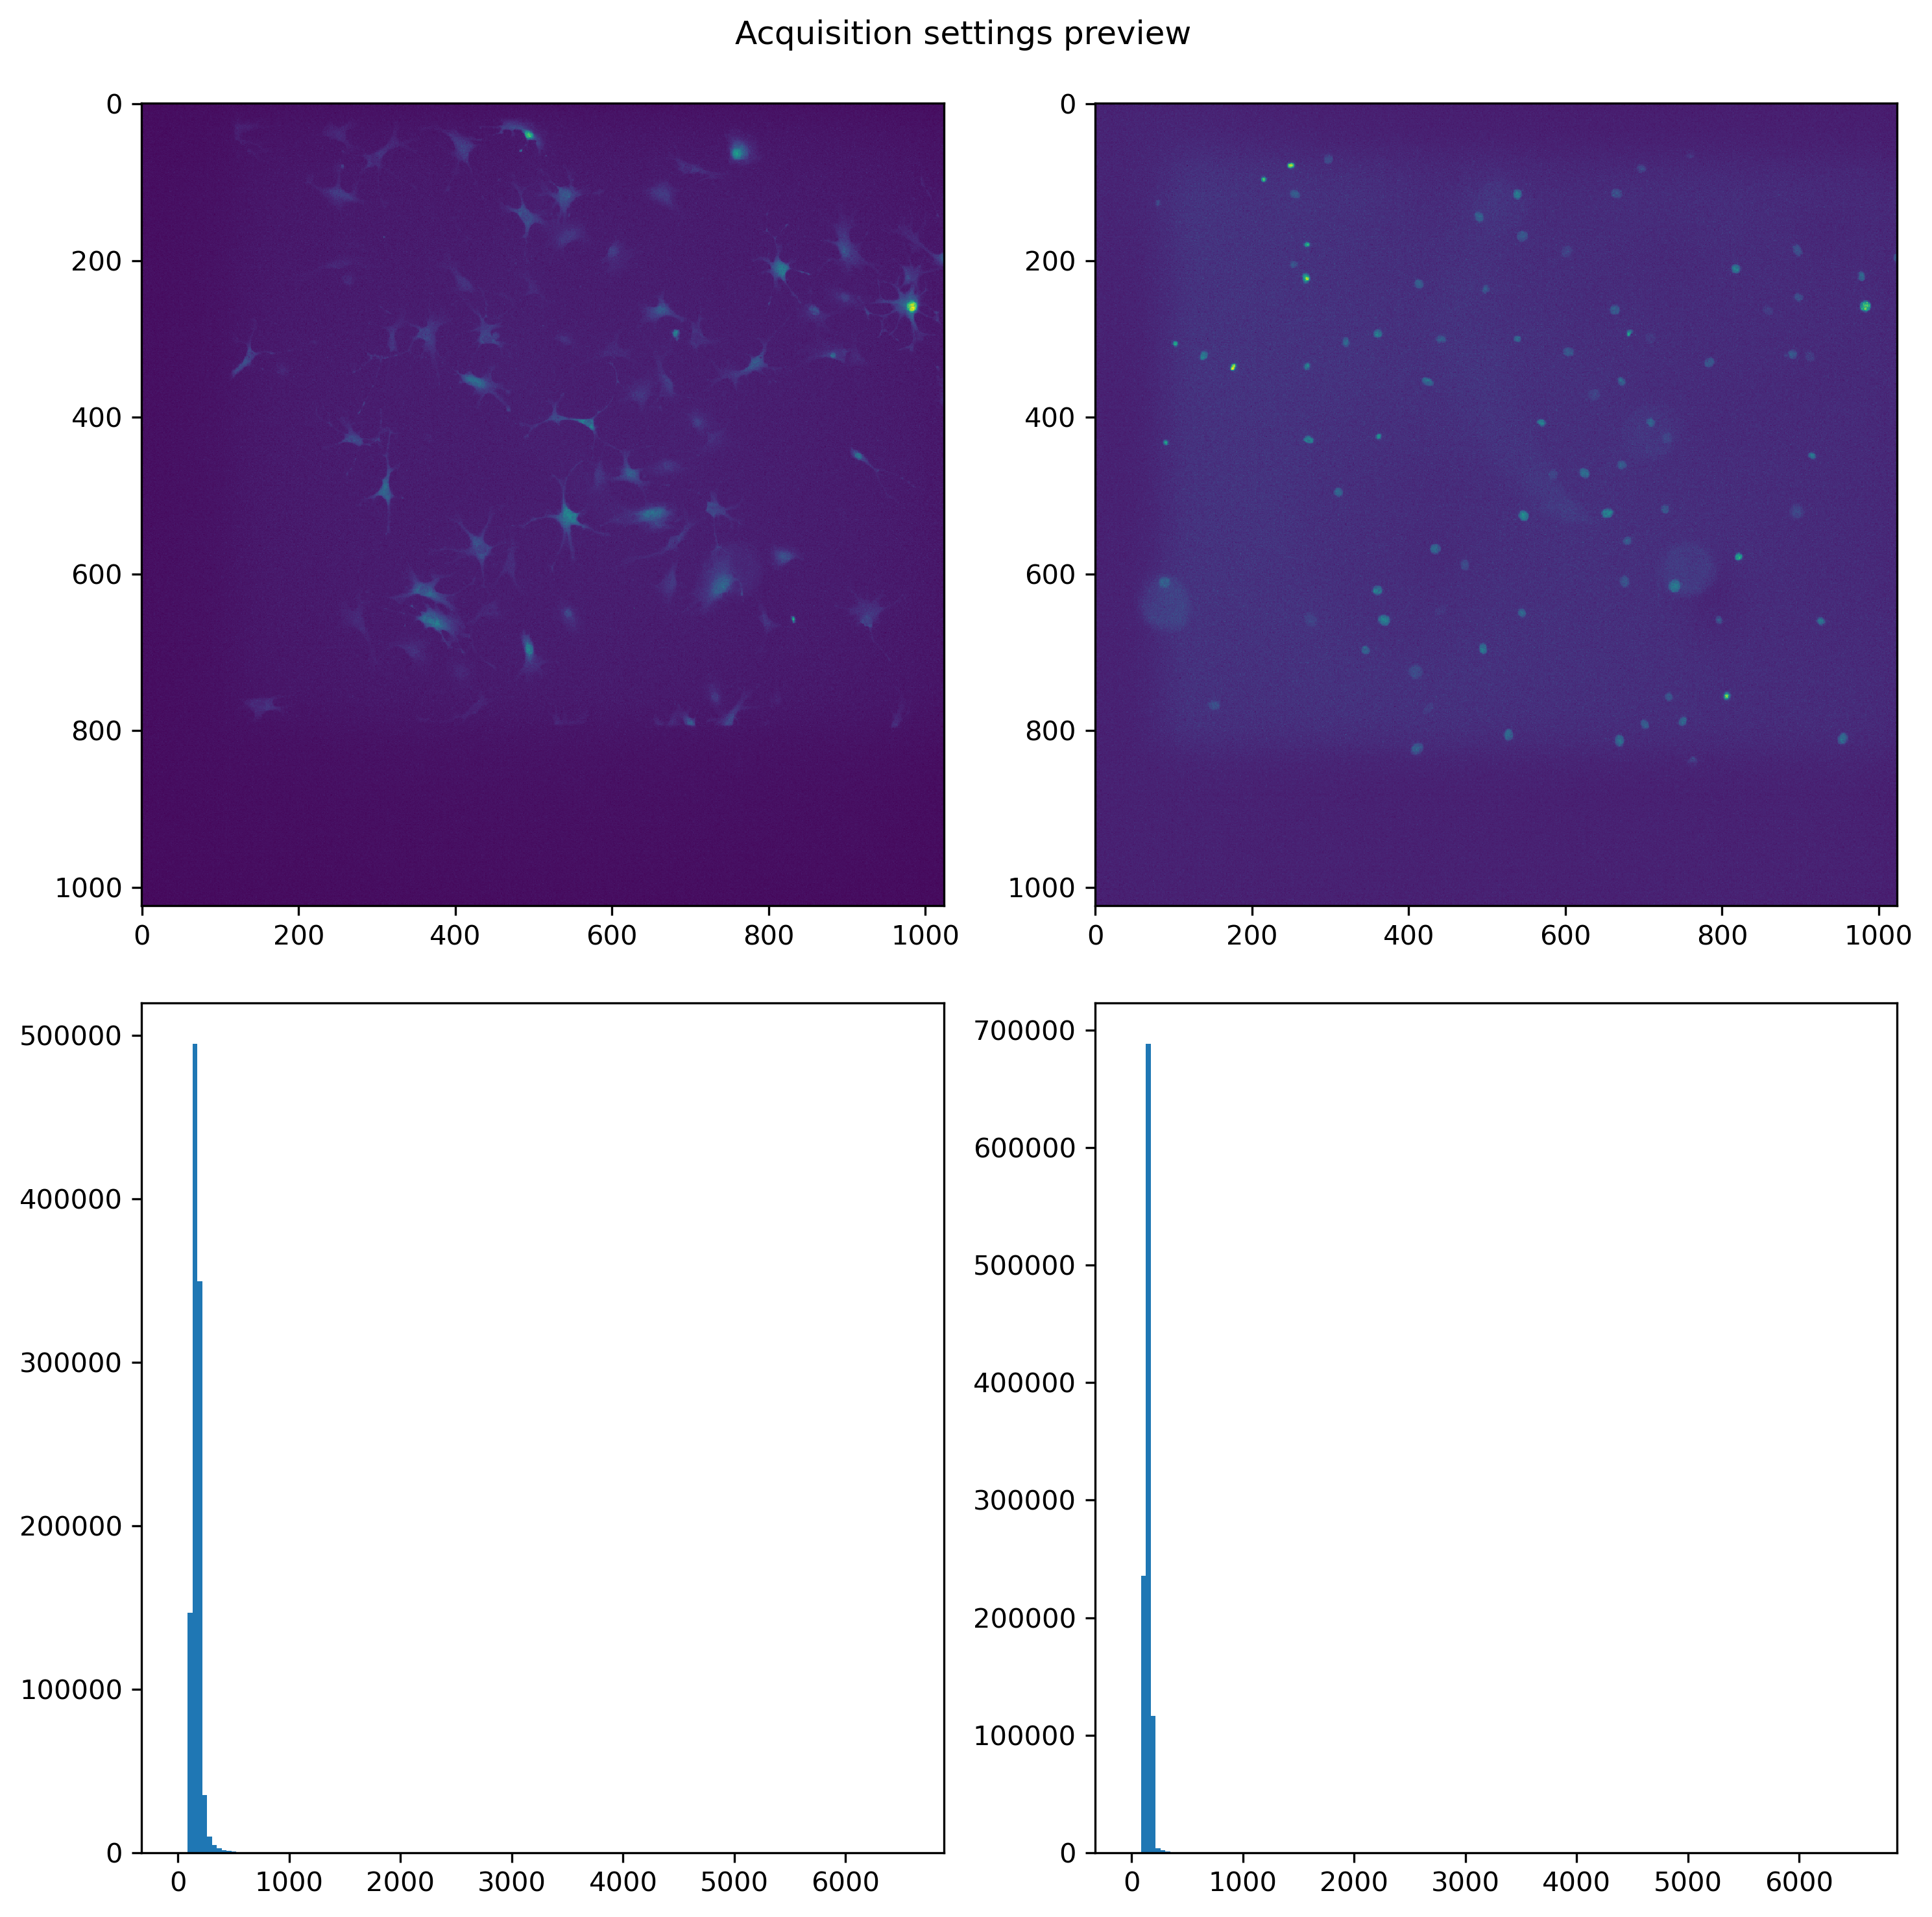

In [24]:
channels_to_acq = [mCherry,miRFP]# ,OPTO_cal]#, OPTO_cal]#OPTO_stim  , OPTO_cal
frame = acq_multi(channels_to_acq,dmd)
plt.figure(figsize = (10,5),dpi = 300)
fig, axs = plt.subplots(2, len(channels_to_acq), figsize = (10,10),dpi = 300)
fig.suptitle('Acquisition settings preview')
#dark_frame = acq_multi_dark(channels_to_acq,dmd)
#frame = frame + dark_frame*-1
for channel_nb, channel in enumerate(channels_to_acq):
    axs[0][channel_nb].imshow(frame[channel_nb,:,:])
    axs[0][channel_nb] = channel.name
for channel_nb, channel in enumerate(channels_to_acq):
    flat = frame[channel_nb,:,:].flatten()
    axs[1][channel_nb].hist(flat, bins=150, range=(0, 65535/10))
plt.tight_layout()
plt.show()


In [25]:
#io.imsave('/Users/micro-manager/Desktop/star_pattern_temp_2.tif',frame)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


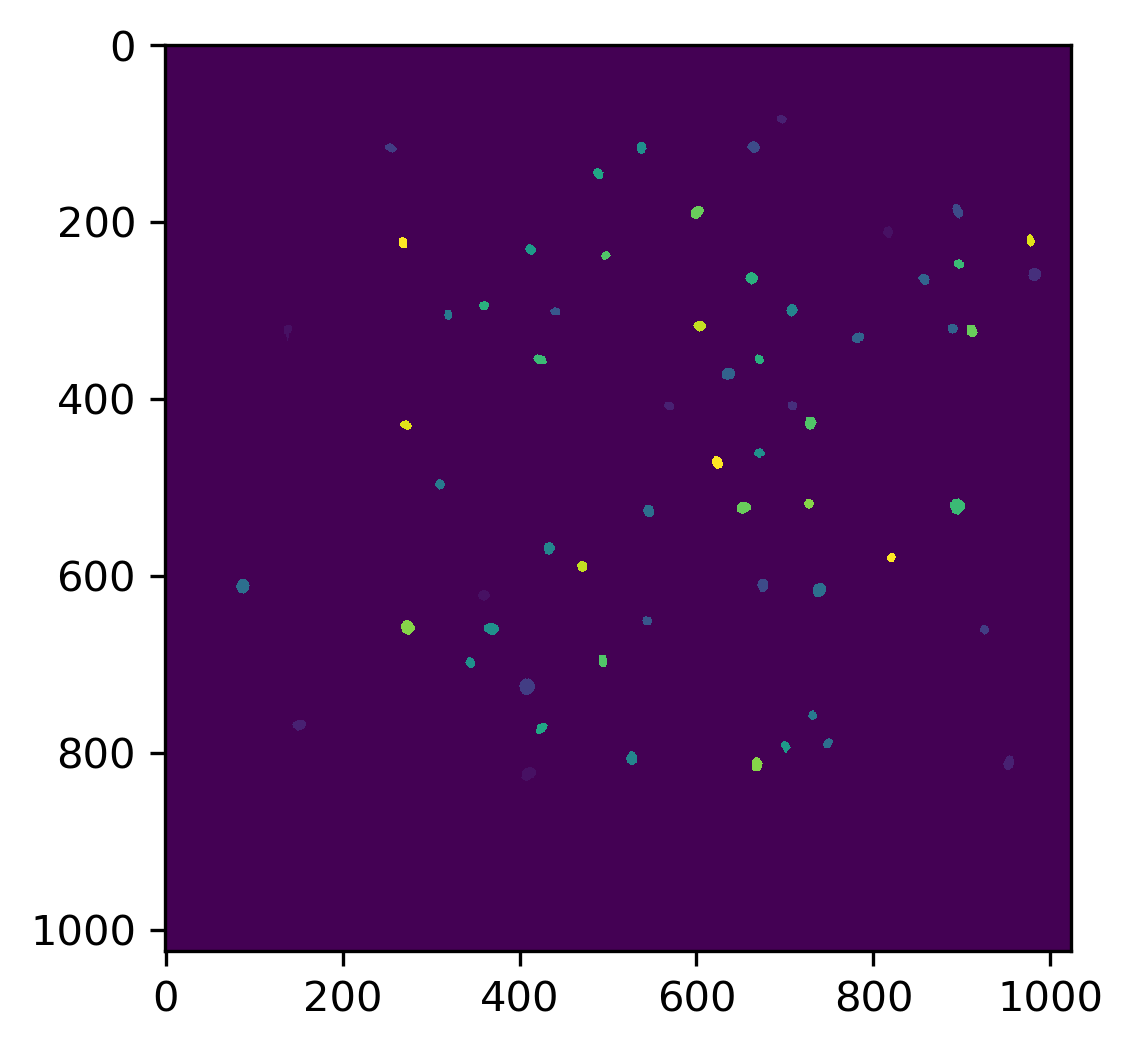

found 66 cells


In [43]:
norm_min = 1
norm_max = 99
stardist_model = StarDist2D.from_pretrained('2D_versatile_fluo')

from csbdeep.utils import Path, normalize
from skimage.morphology import remove_small_objects

## PREPROCESSING ##   
#scale the h2b channel for so StarDist
f_h2b = frame[1,:,:].copy()
f_h2b_scaled = normalize(f_h2b, norm_min,norm_max) #30 95

##Instance segmentation
#https://github.com/stardist/stardist/blob/master/stardist/models/base.py
labels, details = stardist_model.predict_instances(f_h2b_scaled)
# remove small objects:
labels = remove_small_objects(labels, min_size=75, connectivity=1)
plt.figure(dpi=300)
plt.imshow(labels%23)
plt.show()
print(f'found {len(np.unique(labels))} cells')

## Display a mask on the DMD

## Calibrate the DMD for the stimulation channel

Spectra RIGHT: Set Teal_Enable to 0
Spectra RIGHT: Set Violet_Enable to 0
Spectra RIGHT: Set Green_Enable to 0
Spectra RIGHT: Set Blue_Enable to 0
Spectra RIGHT: Set Red_Enable to 0
TIFilterBlock1: Set State to 1
Wheel-C: Set State to 0
Spectra RIGHT: Set White_Level to 0
Spectra RIGHT: Set Cyan_Enable to 1
Spectra RIGHT: Set Cyan_Level to 40


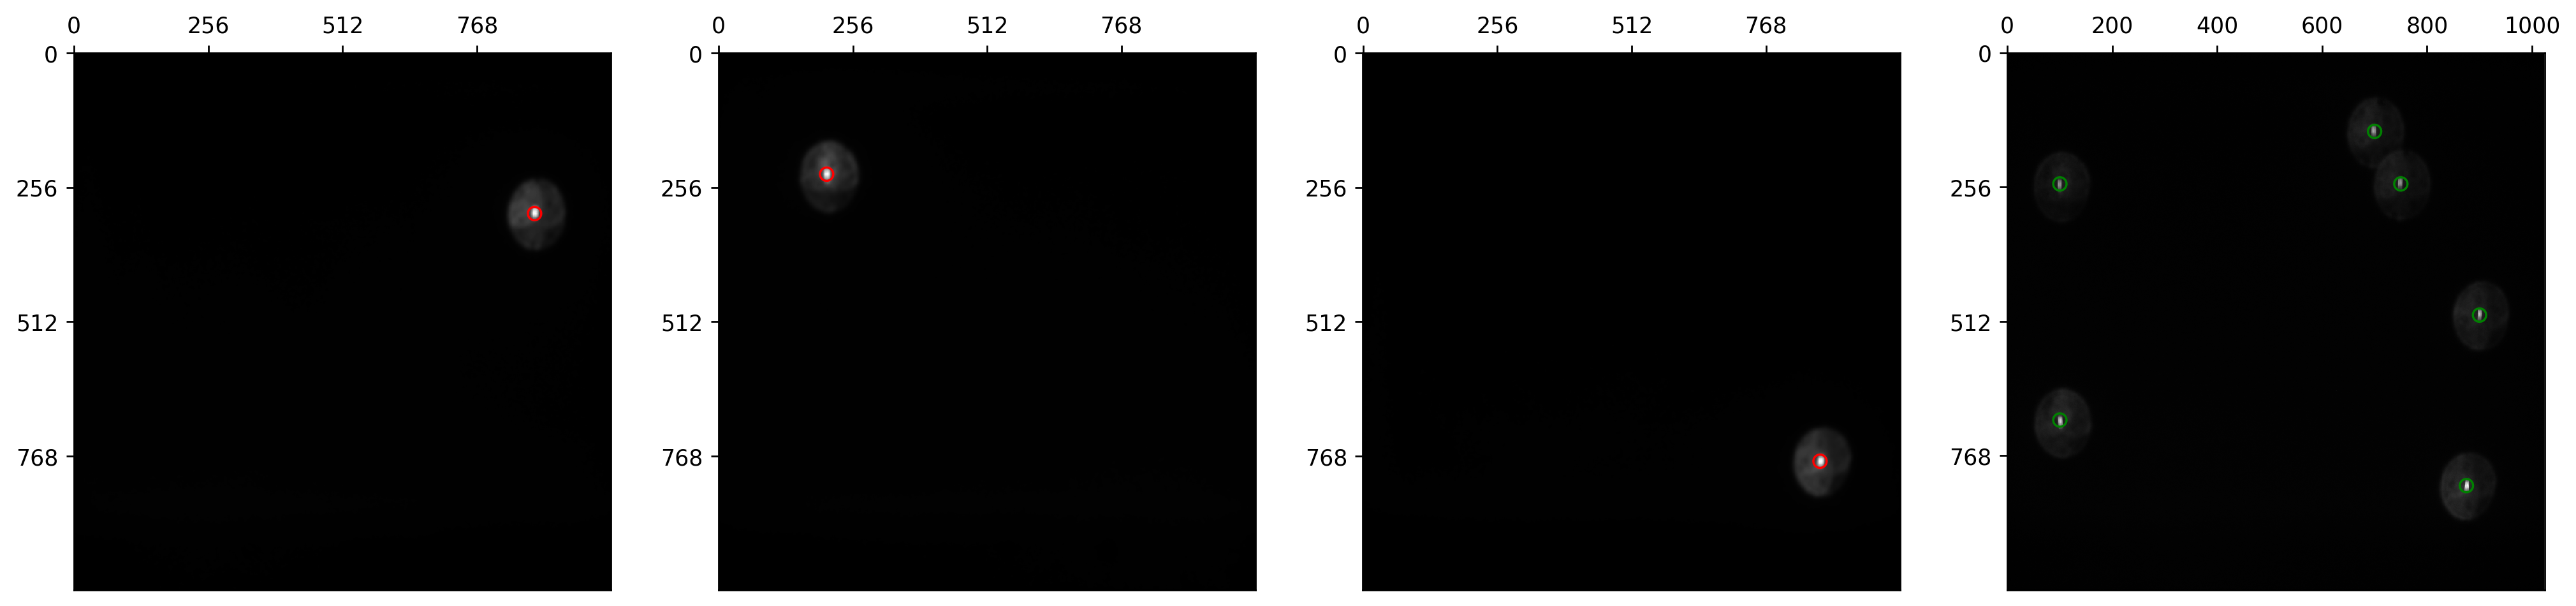

In [31]:
OPTO_cal.apply(core)
affine = dmd.calibrate(verbous = True, blur = 6, circle_size = 5, marker_style = 'o')

#np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_white.npy"), affine)
#np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy"), affine)

In [16]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM_00.npy")

In [25]:
np.save(("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_induce_apo.npy"), affine)

In [16]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_induce_apo.npy")

## Load affine transformation matrix from disk

In [25]:
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_40x_2bin_OPTO_STIM.npy")
affine = np.load("C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\affine_20x_2bin_OPTO_STIM.npy")


## Load micro-manager POS from live MM session

In [32]:
#### STORE
import pickle
with open('C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\pos_list_26.pkl', "wb") as fp:   #Pickling
    pickle.dump(position_list, fp)

In [15]:
#### LOAD
import pickle

with open('C:\\Users\\micro-manager\\Documents\\lhinder\\mm_test_files\\pos_list_26.pkl', "rb") as fp:   #Pickling
    position_list = pickle.load(fp)

## Display the positions and travel paths

128


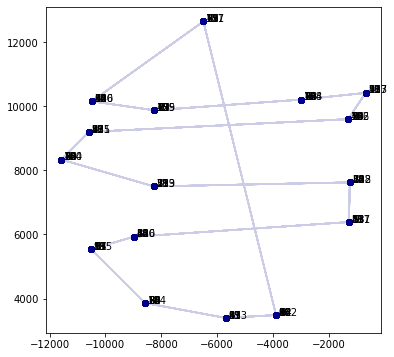

In [33]:
xs = []
ys = []
plt.figure(figsize= (6,6))
for i,pos in enumerate(position_list):
    plt.scatter(pos.x,pos.y,c ='darkblue')
    xs.append(pos.x)
    ys.append(pos.y)
    plt.text(pos.x+100, pos.y, str(i))
print(len(position_list))
plt.plot(xs,ys,c = 'darkblue',alpha = 0.2)
plt.show()

In [20]:
print(len(position_list))
del position_list[16]
print(len(position_list))

17
16


## Initialize the FOVs from a position list


    '''2. Per-frame. Check Autofocus in the MDA windows, configure Autofocus to
    use PFSStatus, and make sure to turn off PFS on the microscope stand
    before starting. If using multiple XY positions, make sure to include
    the Z drive in the position list (see Kurt's explanation above).
    Including the PFSOffset in the position list is optional (include only
    if you want different offsets per position). 


    when I try to
    set the Z position with the setPosition function, the PFS is disabled and I
    have to reactivate it with enableContinuousFocus again.

    I have not worked with the Ti2, but with the Ti, this is baked into the
    microscope firmware: any movement of the Z-position disables the PFS.  I
    suspect that the same is true for the Ti2. Since you want the PFS
    activated in any case, can you simply skip the Z position movement, and
    rely on the PFS to establish the new position? 


    On: PFS is locked and actively correcting focus.
    Off: PFS is deactivated.
    DIS: PFS out of focus and not working. This could be due to sample out of focus, ilumination problem or impossibility to maintain PFS active. 
    ERR: An error occurred with the PFS, speak with the UIC personnel to help you.

    In the Autofocus properties window, select the microscope PFS with the name "TIPFSStatus" and set its status to "ON".
    '''

In [34]:
import pipeline

from importlib import reload
reload(pipeline)
from pipeline import pipeline_single_frame
from pipeline.pipeline_single_frame import add_frame

In [80]:
### Settings for pipeline REAL MODE ###
test_mode = False
time_between_frames = 1*60 #in s
nb_time_steps = int(40)
presets = [miRFP,mCherry]

table_old = None
stim_frame = False
search_range = 15
memory = 3
np.random.seed(6)
lbl_cmap = random_label_cmap()
output_path = 'Z:\\jfrei\\Data\\experiments\\exp_10\\'
#output_path = 'c:\\Users\\micro-manager\\Desktop\\temp_joel\\'


## Create the required folders
required_folders = ['light_mask','raw','mask','stim','tracks','opto_check','mask_ring']
create_folders(output_path,required_folders)

Directory Z:\jfrei\Data\experiments\exp_10\light_mask created 
Directory Z:\jfrei\Data\experiments\exp_10\raw created 
Directory Z:\jfrei\Data\experiments\exp_10\mask created 
Directory Z:\jfrei\Data\experiments\exp_10\stim created 
Directory Z:\jfrei\Data\experiments\exp_10\tracks created 
Directory Z:\jfrei\Data\experiments\exp_10\opto_check created 
Directory Z:\jfrei\Data\experiments\exp_10\mask_ring created 


In [36]:
def wait_function(fov, time_between_frames,experiment_start_time):
    #check the time since the last exposure
    #wait if its less than the temporal resolution we aim for

    current_time = time.time()-experiment_start_time #relative time since start of experiment

    if fov.last_frame_time != None: #not the first frame 
        #check if we need to wait
        time_scince_last_frame = current_time - fov.last_frame_time
        wait_time = time_between_frames-time_scince_last_frame
        if time_scince_last_frame > time_between_frames:
            # we're to slow.
            seconds_behind = (wait_time)*-1
            if seconds_behind > 5: # Hardware cannot keep up!
                print('Seconds behind: ' + str(round(seconds_behind,2)))
                print('Warning: Use less FOVs, set framerate cannot be achieved.') 
        else:
            # we're to fast. Wait the remaining time.
            print('Wait some time: ' + str(round(wait_time, 2)))
            time.sleep(wait_time)
            
    current_time = time.time()-experiment_start_time #relative time scince start of experiment
    fov.last_frame_time = current_time
    return

In [24]:
import numpy as np
import math
#np.round(np.logspace(math.log(10),math.log(1000),10,base=math.e))

In [37]:
stim_regimes = []
for intensity in [5,10,50,100]:
    for duration in [50,200,500,1000]:
        stim_regimes.append((intensity,int(duration)))
print(len(stim_regimes))
print(stim_regimes)

16
[(5, 50), (5, 200), (5, 500), (5, 1000), (10, 50), (10, 200), (10, 500), (10, 1000), (50, 50), (50, 200), (50, 500), (50, 1000), (100, 50), (100, 200), (100, 500), (100, 1000)]


In [40]:
stim_regimes = stim_regimes+stim_regimes
print(len(stim_regimes))


128


In [44]:

import time
from skimage import io
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time
import trackpy as tp
from PIL import Image
import cv2
import onnx
from onnx_tf.backend import prepare
import tensorflow as tf
import skimage
from skimage.segmentation import expand_labels



def coordinates_to_lightmap(coordinates, frame_labeled, fov, diameter = 20):
    '''Takes a list of coordinates [(y,x),(y,x),...] and draws an ellipse on a mask for every point. '''
    diameter = 15
    
    #Elipse properties
    axesLength = (diameter,diameter) #20, 5 for horizontally stretched ellipse #(10,10) for 40x
   # axesLength = (6,6) #20, 5 for horizontally stretched ellipse #(10,10) for 40x
    angle = 0
    startAngle = 0
    endAngle = 360
    color = (1) 
    thickness = -1
    light_mask = np.zeros_like(frame_labeled)

    for xy in coordinates:
        center_coordinates = (int(xy[1]),int(xy[0]))
        light_mask = cv2.ellipse(light_mask, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    return light_mask


def dose_response(table,frame_labeled,fname, fov):
    last_frame = table['frame'].max()
    table_f = table[table['frame']==last_frame]
    if len(table_f['particle']) == 0:
        #no cells in this FOV!
        print('Warning: Empty FOV (no cells detected)')
        return [], np.zeros((1024,1024))
    
    props = skimage.measure.regionprops(frame_labeled)
    props[0].bbox[0]
    rows = [int(prop.centroid[0]) for prop in props] #(min_row, min_col, max_row, max_col)
    cols = [int(prop.centroid[1]) for prop in props] #(row, col).

    #coordinates = [[row-10,col] for row,col in zip(rows,cols)]
    coordinates = [[row,col] for row,col in zip(rows,cols)]
    #turn coordinates of centroids to light mask image
    light_mask = coordinates_to_lightmap(coordinates, np.zeros((1024,1024)),fov)

    frame_labeled_expanded = expand_labels(frame_labeled,10)
    light_mask_mod = np.logical_and(light_mask ,frame_labeled_expanded == 0)

    return table_f['label'].values, light_mask



In [45]:
from pipeline.pipeline_single_frame import extract_ring,extract_features

def add_frame(frame, fov, stardist_model, time_point, stim_frame, output_path, norm_min, norm_max,led_intensity,stim_duration):
    time_start = time.time()

    #name under which the images are stored
    fname = f'{str(fov.index).zfill(2)}_{str(time_point).zfill(5)}'

    ## PREPROCESSING ##   
    #scale the h2b channel for so StarDist
    f_h2b = frame[0,:,:].copy()
    f_h2b_scaled = normalize(f_h2b, norm_min,norm_max)

    ##Instance segmentation
    #https://github.com/stardist/stardist/blob/master/stardist/models/base.py
    labels, details = stardist_model.predict_instances(f_h2b_scaled)

    # remove small objects:
    labels = remove_small_objects(labels, min_size=75, connectivity=1) # min_size to filter out nuclei minimum size. Put on 300 for better selection

    #live_seg_q.put(labels)

    ## FEATURE EXTRACTION ##    
    table_new,labels_rings = extract_features(labels,frame,details)

    table_new['frame']=time_point
    table_new['stim']=False
    table_new['time']=fov.last_frame_time #relative time scince beginning of experiment
    table_new['led_intensity'] = led_intensity
    table_new['stim_duration'] = stim_duration

    ## COMBINE TABLES ##
    #get the previous tracks frame
    table_old = fov.tracks
    

    print(f'FOV {fov.index} type of old tracks: {type(fov.tracks)}.')
    coordinates = np.array(table_new[['x','y']]) #Convert the df to an array of shape (shape: N, ndim) for trackpy

    if time_point == 0: # or table_old == None
        #this is the first frame
        fov.linker.init_level(coordinates, time_point) #extract positions and convert to horizontal list
        table_new['particle'] = fov.linker.particle_ids
        table_tracked = table_new

    else:
        #this is not the first frame
        if len(table_new.index) != 0:
            fov.linker.next_level(coordinates, time_point) #extract positions and convert to horizontal list
            table_new['particle'] = fov.linker.particle_ids
        table_tracked = pd.concat([table_old,table_new])

    #this is against a in trackpy, where the same ID gets assigned twice in one frame
    table_tracked = table_tracked.drop_duplicates(subset=['particle','frame']) 

    ## TRACK ##
    #tp.quiet(suppress=True) #disable output

    #if len(table.index) != 0: # throws error if table is empty
    #    table_tracked = tp.link_df(table, search_range= search_range, memory=memory)
    #    table_tracked = table_tracked.astype({'particle':'int32'}) #decrease precision
    #else:
    #    table_tracked = table
    
    if stim_frame:
        if fov.treatment == 'move_up':
            labels_stim, light_mask = move_up(table_tracked, labels, fname, fov)
        elif fov.treatment == 'move_down':
            labels_stim, light_mask = move_down(table_tracked, labels, fname, fov)
        elif fov.treatment == 'move_control':
            labels_stim, light_mask = move_control(table_tracked, labels, fname, fov)
        elif fov.treatment == 'dose_response':
            labels_stim, light_mask = dose_response(table_tracked, labels, fname, fov)
        else:
            print("Unknown stimulation type: "+ fov.treatment)
        

        light_mask = light_mask.astype(np.uint8)
        fov.light_mask_queue.put(light_mask)  #quickly out the light mask into the queue so we can start the stimulation

        #write in table which labels are stimulated
        table_tracked = table_tracked.reset_index(drop=True)
        stim_index = np.where((table_tracked['frame']==time_point) & (table_tracked['label'].isin(labels_stim)))[0]
        table_tracked.loc[stim_index,'stim']=True


    time_stop = time.time()
    print(f'Time to process one frame: {(time_stop-time_start):0.2f} seconds. Found {len(table_new.index)} cells. Frame {time_point}, FOV {fov.index}.') 

    #only put last 
    
    #put the results into the queue so they can be accessed from parent thread
    fov.tracks_queue.put(table_tracked)


    io.imsave(output_path+'raw\\'+fname+'.tiff',frame, check_contrast=False)
    io.imsave(output_path+'mask\\'+fname+'.tiff',labels, check_contrast=False)
    io.imsave(output_path+'mask_ring\\'+fname+'.tiff',labels_rings, check_contrast=False)
    table_tracked.to_pickle(output_path+'tracks\\'+fname+'.pkl')
    return

In [49]:
#labels_stim, light_mask = dose_response(table_tracked, labels, fname, fov)


In [46]:
# import modules for Experiment description file
from datetime import date
from datetime import datetime
import numpy as np
import math
import os.path

In [81]:
#Change parameters for experiment and enter Experiment description file
nb_parralel_fovs = 16
stimulation_frame = 9
diameter = 15

name_of_file = "Details.txt"
description = "Dose response of 16 FOVS. 6 times experiment. 10X. Shuffled stim regimes. Min size 75"

#Don't change
todays_date = date.today()
current_time = datetime.now()
current_time = current_time.strftime("%H:%M:%S")
position_count = len(position_list)
directory = output_path

In [82]:
#Define functions for Experiment description file
def file_existance(path, filename):
    import os.path
    file_exists = ""
    check_file = os.path.isfile(path+filename)

    if check_file == True:
        file_exists = True
    else:
        file_exists = False

    return file_exists


def existance_validation(file_exists):
    import sys

    if file_exists == True:
        print("File already exists in directory. Change filename or change directory to prevent data loss.")
        sys.exit()
    else:
        print("Good to go!")


# Check if file exists already
existance = file_existance(directory,name_of_file)
existance_validation(existance)

Good to go!


In [83]:
#Write data into file
with open(directory+name_of_file, 'w') as details_file:
    #File path and exp Number
    details_file.write(
        f"{todays_date}\n{current_time}\n\nMicroscope: Mönch\n\nExperiment Path: {output_path}\n\n")
    details_file.write(f"FOV count: {position_count}\n\n")

    #Add used channels
    details_file.write(f"Used Channels:\n\t")
    for channel in channels:
        details_file.write(f"{channel}\t\t")
    details_file.write("\n\n")


    #Number and duration of frames and which frame is stimulated
    details_file.write(
        f"\nFrame details:\n\tNumber of time steps: {nb_time_steps}.\n\tEach time step is {time_between_frames} seconds.\n\tStimulation at time step: {stimulation_frame}. \n\tDiameter:{diameter}\n\n")

    #Add description
    details_file.write(f"Description of experiment:\n\t{description}")

In [54]:
int(len(position_list)/nb_parralel_fovs)

8

In [65]:
import sys

for i in range(60,0,-1):
    sys.stdout.write(str(i)+' ')
    sys.stdout.flush()
    time.sleep(60)
print('Sleep ended')

60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 Sleep ended


In [71]:
fovs = []
for pos_nb, pos in enumerate(position_list):
    treatment = "dose_response"
    fov = FOV(core, pos, treatment, pos_nb,  20, 20,10)
    fovs.append(fov)
print(len(fovs))

fov_counter = 0
for i in range(2):
    start_index = i*nb_parralel_fovs
    stop_index = (i+1)*nb_parralel_fovs
    #print(stim_regimes[start_index:stop_index])
    fovs_current = fovs[start_index:stop_index]
    stim_regimes_current = stim_regimes[start_index:stop_index]
    random.shuffle(stim_regimes_current)
    
    print(stim_regimes_current)

128
[(5, 200), (10, 50), (100, 200), (5, 50), (50, 500), (5, 1000), (10, 200), (50, 200), (5, 500), (100, 500), (100, 1000), (10, 1000), (100, 50), (10, 500), (50, 50), (50, 1000)]
[(50, 1000), (10, 200), (50, 500), (50, 50), (100, 200), (10, 1000), (10, 500), (5, 500), (100, 500), (100, 50), (100, 1000), (50, 200), (5, 200), (5, 1000), (5, 50), (10, 50)]


0


KeyboardInterrupt: 

Start Experiment

In [84]:
fovs = []
for pos_nb, pos in enumerate(position_list):
    treatment = "dose_response"
    fov = FOV(core, pos, treatment, pos_nb,  20, 20,10)
    fovs.append(fov)


### Checks if folder is empty
nbytes = sum(d.stat().st_size for d in os.scandir(output_path+'/raw/') if d.is_file())
ngbytes = nbytes/1000/1000/1000 # B-> KB-> MB-> GB
if ngbytes > 0.01:
    print(':::WARNING:::\nFolder is not empty: '+str(np.round(ngbytes,2))+'GB raw data\n::DISABLE LINE BELOW TO CONTINUE ANYWAYS:::')
    #raise Exception('Folder not empty') #disable this line to allow overwriting



fov_counter = 0
for i in range(8):
    start_index = i*nb_parralel_fovs
    stop_index = (i+1)*nb_parralel_fovs
    #print(stim_regimes[start_index:stop_index])
    fovs_current = fovs[start_index:stop_index]
    stim_regimes_current = stim_regimes[start_index:stop_index]
    random.shuffle(stim_regimes_current)
    
    
    with open(directory+name_of_file, 'a') as details_file:
        for x in stim_regimes_current:
            stim_intensity = x[0]
            stim_length = x[1]
            details_file.write(f"\tFOV {fov_counter}:\tLaser Intensity: {stim_intensity}% \tStimulation Time: {stim_length}ms\n")
            fov_counter += 1   


    ### Start new experiment with 16 FOVs in parralell
    experiment_start_time = time.time()

    for time_step in range(nb_time_steps):
        for fov, stim_regime in zip(fovs_current,stim_regimes_current):    
            fov.move_stage_to_fov()
            stim_frame= False

            if time_step == stimulation_frame:
                stim_frame = True

            wait_function(fov,time_between_frames,experiment_start_time)
            frame = acq_multi(presets,dmd)

            print(frame.shape)
            #start the processing
            if time_step != 0:
                #If not the first frame, get the processed track df from the thread.
                fov.get_tracks_from_thread()
                print(f'FOV {fov.index} track file has {len(fov.tracks.index)} entries.')
                #wait until the old thread terminates
                fov.pipeline_thread.join()

            led_intensity = stim_regime[0]
            stim_duration = stim_regime[1]

            #start new thread
            fov.pipeline_thread = threading.Thread(target = add_frame, args = [frame, fov, stardist_model, time_step, stim_frame, output_path, norm_min, norm_max,led_intensity,stim_duration])
            fov.pipeline_thread.start()

            if stim_frame:
                OPTO_cal.set_power(led_intensity) #Set LED power
                OPTO_cal.camera_exposure_time = stim_duration #Set exposure time

                #wait until the computation is done,plot()
                #then directly project the image
                fov.get_light_mask_from_thread() #wait until stimulation is done            

                stim_img = acq_stim(fov.light_mask,OPTO_cal,affine,dmd)        
                fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
                io.imsave(output_path+'stim\\'+fname+'.tiff',stim_img, check_contrast=False)
                io.imsave(output_path+'light_mask\\'+fname+'.tiff',fov.light_mask, check_contrast=False)

            else:
                # save an empty image so the dimensions match up in napari
                fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
                io.imsave(output_path+'stim\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)
                io.imsave(output_path+'light_mask\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)

            #time_stop = time.time()
            #processing_time = time_stop - time_start
            
            
            if  time_step == nb_time_steps-1:
                #last frame, take exposure of opto sensor
                opto_check_preset = [miRFP,mCherry, OPTO_capture]
                frame = acq_multi(opto_check_preset,dmd)
                io.imsave(output_path+'opto_check\\'+fname+'.tiff',frame, check_contrast=False)

            gc.collect()
    
    minute = 0
    for x in range(600):
        if x % 60 == 0:
            print(minute)
            minute = minute + 1
        time.sleep(1) ##wait until starting a new batch of FOVs


(2, 1024, 1024)
FOV 0 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.24 seconds. Found 26 cells. Frame 0, FOV 0.
(2, 1024, 1024)
FOV 1 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.21 seconds. Found 29 cells. Frame 0, FOV 1.
(2, 1024, 1024)
FOV 2 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.07 seconds. Found 36 cells. Frame 0, FOV 2.
(2, 1024, 1024)
FOV 3 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.07 seconds. Found 33 cells. Frame 0, FOV 3.
(2, 1024, 1024)
FOV 4 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.05 seconds. Found 30 cells. Frame 0, FOV 4.
(2, 1024, 1024)
FOV 5 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.23 seconds. Found 33 cells. Frame 0, FOV 5.
(2, 1024, 1024)
FOV 6 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.23 seconds. Found 24 cells. Frame 0, FOV 6.
(2, 1024, 1024)
FOV 7 type of old tracks: <class 'NoneT

(2, 1024, 1024)
FOV 15 track file has 51 entries.
Wait some time: 0.97
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 25 cells. Frame 2, FOV 15.
(2, 1024, 1024)
FOV 0 track file has 81 entries.
Wait some time: 0.42
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 26 cells. Frame 3, FOV 0.
(2, 1024, 1024)
FOV 1 track file has 88 entries.
Wait some time: 0.1
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 26 cells. Frame 3, FOV 1.
(2, 1024, 1024)
FOV 2 track file has 106 entries.
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 35 cells. Frame 3, FOV 2.
(2, 1024, 1024)
FOV 3 track file has 95 entries.
Wait some time: 0.04
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 33 c

(2, 1024, 1024)
FOV 8 track file has 224 entries.
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 46 cells. Frame 5, FOV 8.
(2, 1024, 1024)
FOV 9 track file has 152 entries.
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 32 cells. Frame 5, FOV 9.
(2, 1024, 1024)
FOV 10 track file has 132 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 27 cells. Frame 5, FOV 10.
(2, 1024, 1024)
FOV 11 track file has 194 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 38 cells. Frame 5, FOV 11.
(2, 1024, 1024)
FOV 12 track file has 63 entries.
Wait some time: 0.24
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.20 seconds. Found 12 cells. Frame 5, FOV 12.
(2, 1024, 1024)
FOV 13 track fi

(2, 1024, 1024)
FOV 1 track file has 231 entries.
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 27 cells. Frame 8, FOV 1.
Wait some time: 0.07
(2, 1024, 1024)
FOV 2 track file has 282 entries.
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 37 cells. Frame 8, FOV 2.
(2, 1024, 1024)
FOV 3 track file has 260 entries.
Wait some time: 0.07
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 33 cells. Frame 8, FOV 3.
(2, 1024, 1024)
FOV 4 track file has 248 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 30 cells. Frame 8, FOV 4.
(2, 1024, 1024)
FOV 5 track file has 270 entries.
Wait some time: 0.96
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 34 cells. Frame 8, FOV 

(2, 1024, 1024)
FOV 4 track file has 311 entries.
Seconds behind: 21.76
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 31 cells. Frame 10, FOV 4.
(2, 1024, 1024)
FOV 5 track file has 338 entries.
Seconds behind: 19.59
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 34 cells. Frame 10, FOV 5.
(2, 1024, 1024)
FOV 6 track file has 241 entries.
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 24 cells. Frame 10, FOV 6.
Seconds behind: 18.08
(2, 1024, 1024)
FOV 7 track file has 174 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 17 cells. Frame 10, FOV 7.
Seconds behind: 15.39
(2, 1024, 1024)
FOV 8 track file has 448 entries.
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. 

(2, 1024, 1024)
FOV 11 track file has 468 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 38 cells. Frame 12, FOV 11.
(2, 1024, 1024)
FOV 12 track file has 150 entries.
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 12 cells. Frame 12, FOV 12.
(2, 1024, 1024)
FOV 13 track file has 223 entries.
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.20 seconds. Found 18 cells. Frame 12, FOV 13.
(2, 1024, 1024)
FOV 14 track file has 304 entries.
Wait some time: 0.03
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 26 cells. Frame 12, FOV 14.
(2, 1024, 1024)
FOV 15 track file has 306 entries.
Wait some time: 1.98
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 26 cells. Frame 12, FOV 15

(2, 1024, 1024)
FOV 4 track file has 470 entries.
Wait some time: 0.06
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 31 cells. Frame 15, FOV 4.
(2, 1024, 1024)
FOV 5 track file has 513 entries.
Wait some time: 0.37
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 35 cells. Frame 15, FOV 5.
(2, 1024, 1024)
FOV 6 track file has 363 entries.
Wait some time: 0.42
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 24 cells. Frame 15, FOV 6.
(2, 1024, 1024)
FOV 7 track file has 259 entries.
Wait some time: 0.36
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 17 cells. Frame 15, FOV 7.
(2, 1024, 1024)
FOV 8 track file has 671 entries.
Wait some time: 0.21
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one fram

(2, 1024, 1024)
FOV 13 track file has 316 entries.
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 18 cells. Frame 17, FOV 13.
(2, 1024, 1024)
FOV 14 track file has 436 entries.
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 26 cells. Frame 17, FOV 14.
(2, 1024, 1024)
FOV 15 track file has 438 entries.
Wait some time: 0.13
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 26 cells. Frame 17, FOV 15.
(2, 1024, 1024)
FOV 0 track file has 479 entries.
Wait some time: 0.02
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 27 cells. Frame 18, FOV 0.
(2, 1024, 1024)
FOV 1 track file has 505 entries.
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 29 cells. Frame 18, FOV 1.
(2, 

(2, 1024, 1024)
FOV 6 track file has 483 entries.
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 25 cells. Frame 20, FOV 6.
(2, 1024, 1024)
FOV 7 track file has 344 entries.
Wait some time: 0.53
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.19 seconds. Found 17 cells. Frame 20, FOV 7.
(2, 1024, 1024)
FOV 8 track file has 892 entries.
Wait some time: 0.33
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 43 cells. Frame 20, FOV 8.
(2, 1024, 1024)
FOV 9 track file has 593 entries.
Wait some time: 0.02
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 28 cells. Frame 20, FOV 9.
(2, 1024, 1024)
FOV 10 track file has 517 entries.
Wait some time: 0.09
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Fo

FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 27 cells. Frame 22, FOV 14.
Wait some time: 0.18
(2, 1024, 1024)
FOV 15 track file has 568 entries.
Wait some time: 0.41
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 26 cells. Frame 22, FOV 15.
(2, 1024, 1024)
FOV 0 track file has 615 entries.
Wait some time: 0.14
FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 27 cells. Frame 23, FOV 0.
(2, 1024, 1024)
FOV 1 track file has 645 entries.
Wait some time: 0.23
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 23, FOV 1.
(2, 1024, 1024)
FOV 2 track file has 817 entries.
Wait some time: 0.23
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 37 cells. Frame 23, FO

(2, 1024, 1024)
FOV 7 track file has 427 entries.
Wait some time: 0.21
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 16 cells. Frame 25, FOV 7.
(2, 1024, 1024)
FOV 8 track file has 1111 entries.
Wait some time: 0.46
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 46 cells. Frame 25, FOV 8.
(2, 1024, 1024)
FOV 9 track file has 734 entries.
Wait some time: 0.46
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 30 cells. Frame 25, FOV 9.
(2, 1024, 1024)
FOV 10 track file has 639 entries.
Wait some time: 0.76
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 26 cells. Frame 25, FOV 10.
(2, 1024, 1024)
FOV 11 track file has 962 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds

FOV 0 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 29 cells. Frame 28, FOV 0.
Wait some time: 0.11
(2, 1024, 1024)
FOV 1 track file has 781 entries.
FOV 1 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 28, FOV 1.
Wait some time: 0.04
(2, 1024, 1024)
FOV 2 track file has 995 entries.
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 37 cells. Frame 28, FOV 2.
(2, 1024, 1024)
FOV 3 track file has 890 entries.
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 31 cells. Frame 28, FOV 3.
(2, 1024, 1024)
FOV 4 track file has 889 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 32 cells. Frame 28, FOV 4.
(2, 1024, 1024)
FOV 5 track file has 967 entries.
FOV 5 type of

(2, 1024, 1024)
FOV 9 track file has 875 entries.
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 27 cells. Frame 30, FOV 9.
(2, 1024, 1024)
FOV 10 track file has 766 entries.
FOV 10 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 26 cells. Frame 30, FOV 10.
(2, 1024, 1024)
FOV 11 track file has 1155 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 38 cells. Frame 30, FOV 11.
(2, 1024, 1024)
FOV 12 track file has 389 entries.
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.20 seconds. Found 14 cells. Frame 30, FOV 12.
(2, 1024, 1024)
FOV 13 track file has 566 entries.
Wait some time: 0.14
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 20 cells. Frame 30, FOV 13.
(2, 1024, 1024)
FOV 1

(2, 1024, 1024)
FOV 2 track file has 1170 entries.
Wait some time: 0.48
FOV 2 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 37 cells. Frame 33, FOV 2.
(2, 1024, 1024)
FOV 3 track file has 1043 entries.
Wait some time: 0.22
FOV 3 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 31 cells. Frame 33, FOV 3.
(2, 1024, 1024)
FOV 4 track file has 1051 entries.
FOV 4 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 33 cells. Frame 33, FOV 4.
(2, 1024, 1024)
FOV 5 track file has 1146 entries.
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 36 cells. Frame 33, FOV 5.
(2, 1024, 1024)
FOV 6 track file has 805 entries.
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 25 cells. Frame 33, FOV 6.
(2, 1024,

(2, 1024, 1024)
FOV 11 track file has 1343 entries.
FOV 11 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 38 cells. Frame 35, FOV 11.
(2, 1024, 1024)
FOV 12 track file has 455 entries.
FOV 12 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 13 cells. Frame 35, FOV 12.
(2, 1024, 1024)
FOV 13 track file has 661 entries.
Wait some time: 0.17
FOV 13 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 20 cells. Frame 35, FOV 13.
(2, 1024, 1024)
FOV 14 track file has 897 entries.
Wait some time: 0.22
FOV 14 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 27 cells. Frame 35, FOV 14.
(2, 1024, 1024)
FOV 15 track file has 904 entries.
FOV 15 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 25 cells. Frame 35, FOV 1

(2, 1024, 1024)
FOV 5 track file has 1322 entries.
FOV 5 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 35 cells. Frame 38, FOV 5.
(2, 1024, 1024)
FOV 6 track file has 931 entries.
FOV 6 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 25 cells. Frame 38, FOV 6.
(2, 1024, 1024)
FOV 7 track file has 636 entries.
FOV 7 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 15 cells. Frame 38, FOV 7.
(2, 1024, 1024)
FOV 8 track file has 1693 entries.
FOV 8 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 46 cells. Frame 38, FOV 8.
(2, 1024, 1024)
FOV 9 track file has 1099 entries.
FOV 9 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 29 cells. Frame 38, FOV 9.
(2, 1024, 1024)
FOV 10 track file has 972 entries.
F

(2, 1024, 1024)
FOV 30 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 0, FOV 30.
(2, 1024, 1024)
FOV 31 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.04 seconds. Found 26 cells. Frame 0, FOV 31.
Wait some time: 3.44
(2, 1024, 1024)
FOV 16 track file has 26 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 1, FOV 16.
(2, 1024, 1024)
FOV 17 track file has 26 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 29 cells. Frame 1, FOV 17.
(2, 1024, 1024)
FOV 18 track file has 35 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.28 seconds. Found 36 cells. Frame 1, FOV 18.
(2, 1024, 1024)
FOV 19 track file has 28 entries.
Wait some time: 0.34
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>

(2, 1024, 1024)
FOV 25 track file has 88 entries.
FOV 25 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 29 cells. Frame 3, FOV 25.
(2, 1024, 1024)
FOV 26 track file has 71 entries.
FOV 26 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 24 cells. Frame 3, FOV 26.
(2, 1024, 1024)
FOV 27 track file has 113 entries.
FOV 27 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 39 cells. Frame 3, FOV 27.
(2, 1024, 1024)
FOV 28 track file has 38 entries.
FOV 28 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 13 cells. Frame 3, FOV 28.
(2, 1024, 1024)
FOV 29 track file has 55 entries.
Wait some time: 0.42
FOV 29 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 17 cells. Frame 3, FOV 29.
(2, 1024, 1024)
FOV 30 track

(2, 1024, 1024)
FOV 19 track file has 179 entries.
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 32 cells. Frame 6, FOV 19.
(2, 1024, 1024)
FOV 20 track file has 191 entries.
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 32 cells. Frame 6, FOV 20.
(2, 1024, 1024)
FOV 21 track file has 199 entries.
Wait some time: 0.23
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 33 cells. Frame 6, FOV 21.
(2, 1024, 1024)
FOV 22 track file has 154 entries.
Wait some time: 0.41
FOV 22 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 26 cells. Frame 6, FOV 22.
(2, 1024, 1024)
FOV 23 track file has 94 entries.
FOV 23 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 17 cells. Frame 6, FOV 23.
(2, 

(2, 1024, 1024)
FOV 28 track file has 102 entries.
Wait some time: 0.02
FOV 28 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 13 cells. Frame 8, FOV 28.
(2, 1024, 1024)
FOV 29 track file has 144 entries.
FOV 29 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 17 cells. Frame 8, FOV 29.
(2, 1024, 1024)
FOV 30 track file has 187 entries.
FOV 30 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 23 cells. Frame 8, FOV 30.
(2, 1024, 1024)
FOV 31 track file has 204 entries.
FOV 31 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 26 cells. Frame 8, FOV 31.
(2, 1024, 1024)
FOV 16 track file has 238 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 25 cells. Frame 9, FOV 16.
(2, 1024, 1024)
FOV 17 t

(2, 1024, 1024)
FOV 28 track file has 126 entries.
Seconds behind: 5.2
FOV 28 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.21 seconds. Found 13 cells. Frame 10, FOV 28.
(2, 1024, 1024)
FOV 29 track file has 180 entries.
FOV 29 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 17 cells. Frame 10, FOV 29.
(2, 1024, 1024)
FOV 30 track file has 233 entries.
FOV 30 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 10, FOV 30.
(2, 1024, 1024)
FOV 31 track file has 254 entries.
FOV 31 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 25 cells. Frame 10, FOV 31.
Wait some time: 0.93
(2, 1024, 1024)
FOV 16 track file has 290 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 25 cells. Frame 11, FOV 16.

(2, 1024, 1024)
FOV 21 track file has 432 entries.
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 33 cells. Frame 13, FOV 21.
(2, 1024, 1024)
FOV 22 track file has 328 entries.
Wait some time: 0.09
FOV 22 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 25 cells. Frame 13, FOV 22.
(2, 1024, 1024)
FOV 23 track file has 208 entries.
Wait some time: 0.02
FOV 23 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 16 cells. Frame 13, FOV 23.
(2, 1024, 1024)
FOV 24 track file has 585 entries.
Wait some time: 0.61
FOV 24 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.28 seconds. Found 44 cells. Frame 13, FOV 24.
(2, 1024, 1024)
FOV 25 track file has 378 entries.
Wait some time: 0.03
FOV 25 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24

(2, 1024, 1024)
FOV 31 track file has 380 entries.
FOV 31 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 15, FOV 31.
Wait some time: 0.08
(2, 1024, 1024)
FOV 16 track file has 419 entries.
Wait some time: 0.13
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 26 cells. Frame 16, FOV 16.
(2, 1024, 1024)
FOV 17 track file has 447 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 28 cells. Frame 16, FOV 17.
(2, 1024, 1024)
FOV 18 track file has 552 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 37 cells. Frame 16, FOV 18.
(2, 1024, 1024)
FOV 19 track file has 483 entries.
Wait some time: 0.31
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 29 ce

(2, 1024, 1024)
FOV 24 track file has 809 entries.
FOV 24 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 47 cells. Frame 18, FOV 24.
(2, 1024, 1024)
FOV 25 track file has 518 entries.
FOV 25 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 27 cells. Frame 18, FOV 25.
(2, 1024, 1024)
FOV 26 track file has 413 entries.
Wait some time: 0.08
FOV 26 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 24 cells. Frame 18, FOV 26.
(2, 1024, 1024)
FOV 27 track file has 678 entries.
Wait some time: 0.41
FOV 27 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 38 cells. Frame 18, FOV 27.
(2, 1024, 1024)
FOV 28 track file has 225 entries.
FOV 28 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.19 seconds. Found 13 cells. Frame 18, FOV 28

FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 21, FOV 16.
(2, 1024, 1024)
FOV 17 track file has 589 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 28 cells. Frame 21, FOV 17.
(2, 1024, 1024)
FOV 18 track file has 729 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 36 cells. Frame 21, FOV 18.
(2, 1024, 1024)
FOV 19 track file has 634 entries.
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 28 cells. Frame 21, FOV 19.
(2, 1024, 1024)
FOV 20 track file has 660 entries.
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 31 cells. Frame 21, FOV 20.
(2, 1024, 1024)
FOV 21 track file has 705 entries.
FOV 21 type of old tracks: <class 'panda

(2, 1024, 1024)
FOV 26 track file has 528 entries.
FOV 26 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 25 cells. Frame 23, FOV 26.
(2, 1024, 1024)
FOV 27 track file has 869 entries.
FOV 27 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 39 cells. Frame 23, FOV 27.
(2, 1024, 1024)
FOV 28 track file has 289 entries.
FOV 28 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 12 cells. Frame 23, FOV 28.
(2, 1024, 1024)
FOV 29 track file has 410 entries.
Wait some time: 0.36
FOV 29 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 19 cells. Frame 23, FOV 29.
(2, 1024, 1024)
FOV 30 track file has 539 entries.
Wait some time: 0.26
FOV 30 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 23 cells. Frame 23, FOV 30

Wait some time: 0.38
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 30 cells. Frame 26, FOV 19.
(2, 1024, 1024)
FOV 20 track file has 823 entries.
Wait some time: 0.59
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 32 cells. Frame 26, FOV 20.
(2, 1024, 1024)
FOV 21 track file has 881 entries.
FOV 21 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 33 cells. Frame 26, FOV 21.
(2, 1024, 1024)
FOV 22 track file has 651 entries.
FOV 22 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 24 cells. Frame 26, FOV 22.
(2, 1024, 1024)
FOV 23 track file has 420 entries.
FOV 23 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 16 cells. Frame 26, FOV 23.
(2, 1024, 1024)
FOV 24 track file has 1168 entrie

(2, 1024, 1024)
FOV 29 track file has 503 entries.
FOV 29 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 19 cells. Frame 28, FOV 29.
Wait some time: 0.07
(2, 1024, 1024)
FOV 30 track file has 657 entries.
FOV 30 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 24 cells. Frame 28, FOV 30.
(2, 1024, 1024)
FOV 31 track file has 721 entries.
FOV 31 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 25 cells. Frame 28, FOV 31.
(2, 1024, 1024)
FOV 16 track file has 762 entries.
Wait some time: 0.04
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 27 cells. Frame 29, FOV 16.
(2, 1024, 1024)
FOV 17 track file has 812 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 30 cells. Frame 29, FOV 17

(2, 1024, 1024)
FOV 22 track file has 777 entries.
FOV 22 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 25 cells. Frame 31, FOV 22.
(2, 1024, 1024)
FOV 23 track file has 501 entries.
FOV 23 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 16 cells. Frame 31, FOV 23.
(2, 1024, 1024)
FOV 24 track file has 1402 entries.
FOV 24 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 44 cells. Frame 31, FOV 24.
(2, 1024, 1024)
FOV 25 track file has 885 entries.
Wait some time: 0.2
FOV 25 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 28 cells. Frame 31, FOV 25.
(2, 1024, 1024)
FOV 26 track file has 723 entries.
FOV 26 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 31, FOV 26.
(2, 1024, 1024)
FOV

(2, 1024, 1024)
FOV 31 track file has 847 entries.
FOV 31 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 26 cells. Frame 33, FOV 31.
Wait some time: 0.24
(2, 1024, 1024)
FOV 16 track file has 895 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 25 cells. Frame 34, FOV 16.
Wait some time: 0.0
(2, 1024, 1024)
FOV 17 track file has 955 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 27 cells. Frame 34, FOV 17.
Wait some time: 0.1
(2, 1024, 1024)
FOV 18 track file has 1187 entries.
Wait some time: 0.31
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 35 cells. Frame 34, FOV 18.
(2, 1024, 1024)
FOV 19 track file has 1023 entries.
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10

(2, 1024, 1024)
FOV 23 track file has 581 entries.
FOV 23 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 16 cells. Frame 36, FOV 23.
(2, 1024, 1024)
FOV 24 track file has 1626 entries.
Wait some time: 0.16
FOV 24 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.30 seconds. Found 44 cells. Frame 36, FOV 24.
(2, 1024, 1024)
FOV 25 track file has 1026 entries.
Wait some time: 0.02
FOV 25 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 30 cells. Frame 36, FOV 25.
(2, 1024, 1024)
FOV 26 track file has 845 entries.
FOV 26 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 25 cells. Frame 36, FOV 26.
(2, 1024, 1024)
FOV 27 track file has 1364 entries.
FOV 27 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 37 cells. Frame 36, FOV

(2, 1024, 1024)
FOV 16 track file has 1022 entries.
FOV 16 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 26 cells. Frame 39, FOV 16.
Seconds behind: 6.71
(2, 1024, 1024)
FOV 17 track file has 1098 entries.
FOV 17 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 29 cells. Frame 39, FOV 17.
Seconds behind: 12.41
(2, 1024, 1024)
FOV 18 track file has 1363 entries.
FOV 18 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 35 cells. Frame 39, FOV 18.
Seconds behind: 18.05
(2, 1024, 1024)
FOV 19 track file has 1172 entries.
FOV 19 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 32 cells. Frame 39, FOV 19.
Seconds behind: 24.18
(2, 1024, 1024)
FOV 20 track file has 1242 entries.
FOV 20 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one fra

(2, 1024, 1024)
FOV 41 track file has 28 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 27 cells. Frame 1, FOV 41.
(2, 1024, 1024)
FOV 42 track file has 23 entries.
FOV 42 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 23 cells. Frame 1, FOV 42.
(2, 1024, 1024)
FOV 43 track file has 39 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 38 cells. Frame 1, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 12 entries.
FOV 44 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 12 cells. Frame 1, FOV 44.
(2, 1024, 1024)
FOV 45 track file has 19 entries.
FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 17 cells. Frame 1, FOV 45.
(2, 1024, 1024)
FOV 46 track file has 23 entries.


(2, 1024, 1024)
FOV 35 track file has 117 entries.
FOV 35 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 31 cells. Frame 4, FOV 35.
(2, 1024, 1024)
FOV 36 track file has 127 entries.
FOV 36 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 31 cells. Frame 4, FOV 36.
(2, 1024, 1024)
FOV 37 track file has 136 entries.
Wait some time: 0.12
FOV 37 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.25 seconds. Found 35 cells. Frame 4, FOV 37.
(2, 1024, 1024)
FOV 38 track file has 98 entries.
FOV 38 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 24 cells. Frame 4, FOV 38.
Wait some time: 0.08
(2, 1024, 1024)
FOV 39 track file has 65 entries.
FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 16 cells. Frame 4, FOV 39.
Wait 

FOV 44 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 12 cells. Frame 6, FOV 44.
(2, 1024, 1024)
FOV 45 track file has 107 entries.
FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 18 cells. Frame 6, FOV 45.
(2, 1024, 1024)
FOV 46 track file has 141 entries.
FOV 46 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 23 cells. Frame 6, FOV 46.
(2, 1024, 1024)
FOV 47 track file has 147 entries.
FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 24 cells. Frame 6, FOV 47.
(2, 1024, 1024)
FOV 32 track file has 181 entries.
FOV 32 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 7, FOV 32.
(2, 1024, 1024)
FOV 33 track file has 190 entries.
FOV 33 type of old tracks: <class 'pandas.cor

Seconds behind: 11.54
(2, 1024, 1024)
FOV 38 track file has 218 entries.
FOV 38 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 24 cells. Frame 9, FOV 38.
Seconds behind: 13.9
(2, 1024, 1024)
FOV 39 track file has 145 entries.
FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 16 cells. Frame 9, FOV 39.
Seconds behind: 15.71
(2, 1024, 1024)
FOV 40 track file has 395 entries.
FOV 40 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 48 cells. Frame 9, FOV 40.
Seconds behind: 18.27
(2, 1024, 1024)
FOV 41 track file has 258 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.18 seconds. Found 29 cells. Frame 9, FOV 41.
Seconds behind: 20.61
(2, 1024, 1024)
FOV 42 track file has 223 entries.
FOV 42 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to pr

FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 16 cells. Frame 11, FOV 39.
(2, 1024, 1024)
FOV 40 track file has 483 entries.
FOV 40 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 45 cells. Frame 11, FOV 40.
(2, 1024, 1024)
FOV 41 track file has 314 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 29 cells. Frame 11, FOV 41.
(2, 1024, 1024)
FOV 42 track file has 275 entries.
FOV 42 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 11, FOV 42.
(2, 1024, 1024)
FOV 43 track file has 409 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 41 cells. Frame 11, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 134 entries.
FOV 44 type of old tracks: <class 'panda

Wait some time: 0.23
FOV 33 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 28 cells. Frame 14, FOV 33.
(2, 1024, 1024)
FOV 34 track file has 503 entries.
FOV 34 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 38 cells. Frame 14, FOV 34.
(2, 1024, 1024)
FOV 35 track file has 408 entries.
FOV 35 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 29 cells. Frame 14, FOV 35.
(2, 1024, 1024)
FOV 36 track file has 437 entries.
FOV 36 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 29 cells. Frame 14, FOV 36.
(2, 1024, 1024)
FOV 37 track file has 488 entries.
Wait some time: 0.08
FOV 37 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 35 cells. Frame 14, FOV 37.
(2, 1024, 1024)
FOV 38 track file has 341 entries

(2, 1024, 1024)
FOV 43 track file has 599 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 41 cells. Frame 16, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 192 entries.
FOV 44 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 12 cells. Frame 16, FOV 44.
(2, 1024, 1024)
FOV 45 track file has 288 entries.
FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 18 cells. Frame 16, FOV 45.
(2, 1024, 1024)
FOV 46 track file has 379 entries.
FOV 46 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 24 cells. Frame 16, FOV 46.
(2, 1024, 1024)
FOV 47 track file has 393 entries.
FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 24 cells. Frame 16, FOV 47.
(2, 1024, 1024)
FOV 32 track file has 43

(2, 1024, 1024)
FOV 37 track file has 665 entries.
FOV 37 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 33 cells. Frame 19, FOV 37.
(2, 1024, 1024)
FOV 38 track file has 463 entries.
FOV 38 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 19, FOV 38.
(2, 1024, 1024)
FOV 39 track file has 306 entries.
FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 17 cells. Frame 19, FOV 39.
(2, 1024, 1024)
FOV 40 track file has 837 entries.
FOV 40 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 44 cells. Frame 19, FOV 40.
(2, 1024, 1024)
FOV 41 track file has 541 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 25 cells. Frame 19, FOV 41.
(2, 1024, 1024)
FOV 42 track file has 48

FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 21, FOV 47.
Wait some time: 0.01
(2, 1024, 1024)
FOV 32 track file has 553 entries.
Wait some time: 0.21
FOV 32 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 22, FOV 32.
(2, 1024, 1024)
FOV 33 track file has 599 entries.
FOV 33 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 28 cells. Frame 22, FOV 33.
(2, 1024, 1024)
FOV 34 track file has 792 entries.
FOV 34 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 36 cells. Frame 22, FOV 34.
(2, 1024, 1024)
FOV 35 track file has 639 entries.
FOV 35 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 32 cells. Frame 22, FOV 35.
(2, 1024, 1024)
FOV 36 track file has 689 entries

(2, 1024, 1024)
FOV 41 track file has 679 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 24, FOV 41.
Wait some time: 0.07
(2, 1024, 1024)
FOV 42 track file has 612 entries.
FOV 42 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 24, FOV 42.
(2, 1024, 1024)
FOV 43 track file has 906 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 38 cells. Frame 24, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 286 entries.
FOV 44 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 11 cells. Frame 24, FOV 44.
(2, 1024, 1024)
FOV 45 track file has 437 entries.
FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 19 cells. Frame 24, FOV 45.
(2, 1024, 1024)
FOV

(2, 1024, 1024)
FOV 35 track file has 786 entries.
FOV 35 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 30 cells. Frame 27, FOV 35.
(2, 1024, 1024)
FOV 36 track file has 842 entries.
FOV 36 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 33 cells. Frame 27, FOV 36.
(2, 1024, 1024)
FOV 37 track file has 943 entries.
FOV 37 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 36 cells. Frame 27, FOV 37.
(2, 1024, 1024)
FOV 38 track file has 661 entries.
FOV 38 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 26 cells. Frame 27, FOV 38.
(2, 1024, 1024)
FOV 39 track file has 435 entries.
FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 16 cells. Frame 27, FOV 39.
(2, 1024, 1024)
FOV 40 track file has 11

FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 20 cells. Frame 29, FOV 45.
(2, 1024, 1024)
FOV 46 track file has 684 entries.
FOV 46 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 23 cells. Frame 29, FOV 46.
(2, 1024, 1024)
FOV 47 track file has 712 entries.
FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 24 cells. Frame 29, FOV 47.
(2, 1024, 1024)
FOV 32 track file has 751 entries.
FOV 32 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 25 cells. Frame 30, FOV 32.
(2, 1024, 1024)
FOV 33 track file has 814 entries.
FOV 33 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 30 cells. Frame 30, FOV 33.
(2, 1024, 1024)
FOV 34 track file has 1075 entries.
FOV 34 type of old tracks: <class 'pand

(2, 1024, 1024)
FOV 39 track file has 514 entries.
FOV 39 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 15 cells. Frame 32, FOV 39.
(2, 1024, 1024)
FOV 40 track file has 1408 entries.
FOV 40 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 44 cells. Frame 32, FOV 40.
(2, 1024, 1024)
FOV 41 track file has 903 entries.
FOV 41 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 27 cells. Frame 32, FOV 41.
(2, 1024, 1024)
FOV 42 track file has 830 entries.
FOV 42 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 28 cells. Frame 32, FOV 42.
(2, 1024, 1024)
FOV 43 track file has 1207 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 38 cells. Frame 32, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 

FOV 32 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 25 cells. Frame 35, FOV 32.
(2, 1024, 1024)
FOV 33 track file has 948 entries.
FOV 33 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 35, FOV 33.
(2, 1024, 1024)
FOV 34 track file has 1254 entries.
FOV 34 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 36 cells. Frame 35, FOV 34.
(2, 1024, 1024)
FOV 35 track file has 1013 entries.
FOV 35 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 28 cells. Frame 35, FOV 35.
(2, 1024, 1024)
FOV 36 track file has 1097 entries.
FOV 36 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 33 cells. Frame 35, FOV 36.
(2, 1024, 1024)
FOV 37 track file has 1215 entries.
FOV 37 type of old tracks: <class 'p

(2, 1024, 1024)
FOV 43 track file has 1393 entries.
FOV 43 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 40 cells. Frame 37, FOV 43.
(2, 1024, 1024)
FOV 44 track file has 431 entries.
Wait some time: 0.23
FOV 44 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 12 cells. Frame 37, FOV 44.
(2, 1024, 1024)
FOV 45 track file has 688 entries.
Wait some time: 0.04
FOV 45 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 19 cells. Frame 37, FOV 45.
(2, 1024, 1024)
FOV 46 track file has 866 entries.
FOV 46 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 23 cells. Frame 37, FOV 46.
Wait some time: 0.59
(2, 1024, 1024)
FOV 47 track file has 904 entries.
FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 25 c

(2, 1024, 1024)
FOV 47 track file has 953 entries.
FOV 47 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 24 cells. Frame 39, FOV 47.
0
1
2
3
4
5
6
7
8
9
(2, 1024, 1024)
FOV 48 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 0, FOV 48.
(2, 1024, 1024)
FOV 49 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.08 seconds. Found 28 cells. Frame 0, FOV 49.
(2, 1024, 1024)
FOV 50 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.13 seconds. Found 36 cells. Frame 0, FOV 50.
(2, 1024, 1024)
FOV 51 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.12 seconds. Found 27 cells. Frame 0, FOV 51.
(2, 1024, 1024)
FOV 52 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.13 seconds. Found 31 cells. Frame 0, FOV 52.
(2, 1024, 1024)
FOV 53 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.27 seconds.

(2, 1024, 1024)
FOV 62 track file has 45 entries.
FOV 62 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 23 cells. Frame 2, FOV 62.
(2, 1024, 1024)
FOV 63 track file has 48 entries.
FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 2, FOV 63.
(2, 1024, 1024)
FOV 48 track file has 79 entries.
FOV 48 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 26 cells. Frame 3, FOV 48.
(2, 1024, 1024)
FOV 49 track file has 83 entries.
FOV 49 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 29 cells. Frame 3, FOV 49.
(2, 1024, 1024)
FOV 50 track file has 105 entries.
FOV 50 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 35 cells. Frame 3, FOV 50.
(2, 1024, 1024)
FOV 51 track file has 87 entries.

(2, 1024, 1024)
FOV 56 track file has 219 entries.
FOV 56 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 47 cells. Frame 5, FOV 56.
(2, 1024, 1024)
FOV 57 track file has 138 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 5, FOV 57.
(2, 1024, 1024)
FOV 58 track file has 134 entries.
FOV 58 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 28 cells. Frame 5, FOV 58.
(2, 1024, 1024)
FOV 59 track file has 184 entries.
FOV 59 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 36 cells. Frame 5, FOV 59.
(2, 1024, 1024)
FOV 60 track file has 55 entries.
FOV 60 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 11 cells. Frame 5, FOV 60.
(2, 1024, 1024)
FOV 61 track file has 93 entri

(2, 1024, 1024)
FOV 50 track file has 283 entries.
FOV 50 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 33 cells. Frame 8, FOV 50.
(2, 1024, 1024)
FOV 51 track file has 228 entries.
FOV 51 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 27 cells. Frame 8, FOV 51.
(2, 1024, 1024)
FOV 52 track file has 242 entries.
FOV 52 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 30 cells. Frame 8, FOV 52.
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 53 track file has 264 entries.
FOV 53 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 32 cells. Frame 8, FOV 53.
(2, 1024, 1024)
FOV 54 track file has 196 entries.
FOV 54 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 25 cells. Frame 8, FOV 54.
(2,

(2, 1024, 1024)
FOV 53 track file has 329 entries.
Seconds behind: 20.8
FOV 53 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 33 cells. Frame 10, FOV 53.
(2, 1024, 1024)
FOV 54 track file has 244 entries.
FOV 54 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Seconds behind: 17.82
Time to process one frame: 1.07 seconds. Found 23 cells. Frame 10, FOV 54.
(2, 1024, 1024)
FOV 55 track file has 158 entries.
FOV 55 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 16 cells. Frame 10, FOV 55.
Seconds behind: 15.89
(2, 1024, 1024)
FOV 56 track file has 443 entries.
FOV 56 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 49 cells. Frame 10, FOV 56.
Seconds behind: 14.15
(2, 1024, 1024)
FOV 57 track file has 273 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1

(2, 1024, 1024)
FOV 60 track file has 132 entries.
FOV 60 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 11 cells. Frame 12, FOV 60.
Wait some time: 0.05
(2, 1024, 1024)
FOV 61 track file has 217 entries.
FOV 61 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Wait some time: 0.41
Time to process one frame: 1.04 seconds. Found 19 cells. Frame 12, FOV 61.
(2, 1024, 1024)
FOV 62 track file has 273 entries.
FOV 62 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 24 cells. Frame 12, FOV 62.
Wait some time: 0.12
(2, 1024, 1024)
FOV 63 track file has 286 entries.
FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 12, FOV 63.
Wait some time: 0.16
(2, 1024, 1024)
FOV 48 track file has 336 entries.
Wait some time: 0.05
FOV 48 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to pr

(2, 1024, 1024)
FOV 54 track file has 369 entries.
FOV 54 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 24 cells. Frame 15, FOV 54.
Wait some time: 0.06
(2, 1024, 1024)
FOV 55 track file has 238 entries.
FOV 55 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 16 cells. Frame 15, FOV 55.
Wait some time: 0.02
(2, 1024, 1024)
FOV 56 track file has 664 entries.
FOV 56 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Wait some time: 0.31
Time to process one frame: 1.16 seconds. Found 46 cells. Frame 15, FOV 56.
(2, 1024, 1024)
FOV 57 track file has 409 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 29 cells. Frame 15, FOV 57.
(2, 1024, 1024)
FOV 58 track file has 406 entries.
FOV 58 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 28 ce

FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 25 cells. Frame 17, FOV 63.
(2, 1024, 1024)
FOV 48 track file has 461 entries.
FOV 48 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 18, FOV 48.
(2, 1024, 1024)
FOV 49 track file has 493 entries.
FOV 49 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 30 cells. Frame 18, FOV 49.
(2, 1024, 1024)
FOV 50 track file has 632 entries.
FOV 50 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 35 cells. Frame 18, FOV 50.
(2, 1024, 1024)
FOV 51 track file has 508 entries.
FOV 51 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 29 cells. Frame 18, FOV 51.
(2, 1024, 1024)
FOV 52 track file has 558 entries.
FOV 52 type of old tracks: <class 'panda

(2, 1024, 1024)
FOV 57 track file has 541 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 30 cells. Frame 20, FOV 57.
(2, 1024, 1024)
FOV 58 track file has 541 entries.
FOV 58 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 20, FOV 58.
(2, 1024, 1024)
FOV 59 track file has 738 entries.
FOV 59 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 41 cells. Frame 20, FOV 59.
(2, 1024, 1024)
FOV 60 track file has 218 entries.
FOV 60 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 10 cells. Frame 20, FOV 60.
(2, 1024, 1024)
FOV 61 track file has 370 entries.
FOV 61 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 19 cells. Frame 20, FOV 61.
Wait some time: 0.03
(2, 1024, 1024)
FOV

Wait some time: 0.48
FOV 51 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 27 cells. Frame 23, FOV 51.
(2, 1024, 1024)
FOV 52 track file has 713 entries.
Wait some time: 0.63
FOV 52 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 33 cells. Frame 23, FOV 52.
(2, 1024, 1024)
FOV 53 track file has 748 entries.
FOV 53 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 34 cells. Frame 23, FOV 53.
(2, 1024, 1024)
FOV 54 track file has 562 entries.
FOV 54 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 23 cells. Frame 23, FOV 54.
(2, 1024, 1024)
FOV 55 track file has 359 entries.
FOV 55 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 15 cells. Frame 23, FOV 55.
(2, 1024, 1024)
FOV 56 track file has 1021 entrie

(2, 1024, 1024)
FOV 61 track file has 466 entries.
FOV 61 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 20 cells. Frame 25, FOV 61.
Wait some time: 0.09
(2, 1024, 1024)
FOV 62 track file has 569 entries.
FOV 62 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 22 cells. Frame 25, FOV 62.
(2, 1024, 1024)
FOV 63 track file has 598 entries.
FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 25, FOV 63.
(2, 1024, 1024)
FOV 48 track file has 666 entries.
FOV 48 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 26 cells. Frame 26, FOV 48.
(2, 1024, 1024)
FOV 49 track file has 709 entries.
FOV 49 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 26, FOV 49.
(2, 1024, 1024)
FOV

FOV 55 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 15 cells. Frame 28, FOV 55.
(2, 1024, 1024)
FOV 56 track file has 1243 entries.
FOV 56 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 45 cells. Frame 28, FOV 56.
(2, 1024, 1024)
FOV 57 track file has 765 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 28, FOV 57.
(2, 1024, 1024)
FOV 58 track file has 764 entries.
FOV 58 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 28 cells. Frame 28, FOV 58.
(2, 1024, 1024)
FOV 59 track file has 1044 entries.
FOV 59 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 41 cells. Frame 28, FOV 59.
(2, 1024, 1024)
FOV 60 track file has 300 entries.
FOV 60 type of old tracks: <class 'pan

(2, 1024, 1024)
FOV 49 track file has 845 entries.
FOV 49 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 29 cells. Frame 31, FOV 49.
(2, 1024, 1024)
FOV 50 track file has 1091 entries.
FOV 50 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 35 cells. Frame 31, FOV 50.
(2, 1024, 1024)
FOV 51 track file has 882 entries.
FOV 51 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 31, FOV 51.
(2, 1024, 1024)
FOV 52 track file has 950 entries.
FOV 52 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 30 cells. Frame 31, FOV 52.
(2, 1024, 1024)
FOV 53 track file has 1014 entries.
FOV 53 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 34 cells. Frame 31, FOV 53.
(2, 1024, 1024)
FOV 54 track file has 

(2, 1024, 1024)
FOV 59 track file has 1241 entries.
FOV 59 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 36 cells. Frame 33, FOV 59.
(2, 1024, 1024)
FOV 60 track file has 352 entries.
FOV 60 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 10 cells. Frame 33, FOV 60.
(2, 1024, 1024)
FOV 61 track file has 616 entries.
FOV 61 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 21 cells. Frame 33, FOV 61.
(2, 1024, 1024)
FOV 62 track file has 746 entries.
FOV 62 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 22 cells. Frame 33, FOV 62.
(2, 1024, 1024)
FOV 63 track file has 791 entries.
FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 24 cells. Frame 33, FOV 63.
(2, 1024, 1024)
FOV 48 track file has 8

(2, 1024, 1024)
FOV 53 track file has 1183 entries.
Wait some time: 0.18
FOV 53 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 33 cells. Frame 36, FOV 53.
(2, 1024, 1024)
FOV 54 track file has 880 entries.
FOV 54 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 27 cells. Frame 36, FOV 54.
Wait some time: 0.21
(2, 1024, 1024)
FOV 55 track file has 546 entries.
FOV 55 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 13 cells. Frame 36, FOV 55.
Wait some time: 0.03
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 56 track file has 1602 entries.
FOV 56 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 45 cells. Frame 36, FOV 56.
(2, 1024, 1024)
FOV 57 track file has 998 entries.
FOV 57 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to 

(2, 1024, 1024)
FOV 63 track file has 911 entries.
FOV 63 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 38, FOV 63.
(2, 1024, 1024)
FOV 48 track file has 991 entries.
FOV 48 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 39, FOV 48.
Seconds behind: 6.42
(2, 1024, 1024)
FOV 49 track file has 1070 entries.
FOV 49 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 29 cells. Frame 39, FOV 49.
Seconds behind: 12.13
(2, 1024, 1024)
FOV 50 track file has 1366 entries.
FOV 50 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 36 cells. Frame 39, FOV 50.
Seconds behind: 18.15
(2, 1024, 1024)
FOV 51 track file has 1113 entries.
FOV 51 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 

(2, 1024, 1024)
FOV 72 track file has 45 entries.
FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.27 seconds. Found 44 cells. Frame 1, FOV 72.
(2, 1024, 1024)
FOV 73 track file has 27 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 29 cells. Frame 1, FOV 73.
(2, 1024, 1024)
FOV 74 track file has 28 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 28 cells. Frame 1, FOV 74.
(2, 1024, 1024)
FOV 75 track file has 38 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 37 cells. Frame 1, FOV 75.
(2, 1024, 1024)
FOV 76 track file has 10 entries.
FOV 76 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.02 seconds. Found 10 cells. Frame 1, FOV 76.
(2, 1024, 1024)
FOV 77 track file has 19 entries.


(2, 1024, 1024)
FOV 67 track file has 112 entries.
FOV 67 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 4, FOV 67.
(2, 1024, 1024)
FOV 68 track file has 116 entries.
FOV 68 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 29 cells. Frame 4, FOV 68.
(2, 1024, 1024)
FOV 69 track file has 133 entries.
FOV 69 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 33 cells. Frame 4, FOV 69.
(2, 1024, 1024)
FOV 70 track file has 105 entries.
FOV 70 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 4, FOV 70.
(2, 1024, 1024)
FOV 71 track file has 58 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 14 cells. Frame 4, FOV 71.
(2, 1024, 1024)
FOV 72 track file has 173 entr

(2, 1024, 1024)
FOV 78 track file has 127 entries.
FOV 78 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 22 cells. Frame 6, FOV 78.
(2, 1024, 1024)
FOV 79 track file has 146 entries.
FOV 79 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 6, FOV 79.
(2, 1024, 1024)
FOV 64 track file has 179 entries.
FOV 64 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 27 cells. Frame 7, FOV 64.
(2, 1024, 1024)
FOV 65 track file has 198 entries.
FOV 65 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 29 cells. Frame 7, FOV 65.
(2, 1024, 1024)
FOV 66 track file has 244 entries.
FOV 66 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 35 cells. Frame 7, FOV 66.
(2, 1024, 1024)
FOV 67 track file has 197 ent

(2, 1024, 1024)
FOV 71 track file has 127 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 15 cells. Frame 9, FOV 71.
Seconds behind: 16.98
(2, 1024, 1024)
FOV 72 track file has 393 entries.
FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.22 seconds. Found 46 cells. Frame 9, FOV 72.
Seconds behind: 18.78
(2, 1024, 1024)
FOV 73 track file has 249 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 29 cells. Frame 9, FOV 73.
Seconds behind: 21.02
(2, 1024, 1024)
FOV 74 track file has 254 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 29 cells. Frame 9, FOV 74.
Seconds behind: 22.95
(2, 1024, 1024)
FOV 75 track file has 343 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.20

FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 45 cells. Frame 11, FOV 72.
(2, 1024, 1024)
FOV 73 track file has 306 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 28 cells. Frame 11, FOV 73.
(2, 1024, 1024)
FOV 74 track file has 311 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 29 cells. Frame 11, FOV 74.
(2, 1024, 1024)
FOV 75 track file has 421 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 38 cells. Frame 11, FOV 75.
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 76 track file has 112 entries.
FOV 76 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 10 cells. Frame 11, FOV 76.
(2, 1024, 1024)
FOV 77 track file has 202 entries

(2, 1024, 1024)
FOV 67 track file has 394 entries.
FOV 67 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 28 cells. Frame 14, FOV 67.
(2, 1024, 1024)
FOV 68 track file has 407 entries.
FOV 68 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 14, FOV 68.
(2, 1024, 1024)
FOV 69 track file has 467 entries.
FOV 69 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.26 seconds. Found 34 cells. Frame 14, FOV 69.
(2, 1024, 1024)
FOV 70 track file has 354 entries.
FOV 70 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 24 cells. Frame 14, FOV 70.
(2, 1024, 1024)
FOV 71 track file has 198 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.03 seconds. Found 14 cells. Frame 14, FOV 71.
(2, 1024, 1024)
FOV 72 track file has 60

(2, 1024, 1024)
FOV 78 track file has 346 entries.
FOV 78 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 24 cells. Frame 16, FOV 78.
(2, 1024, 1024)
FOV 79 track file has 392 entries.
FOV 79 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 24 cells. Frame 16, FOV 79.
(2, 1024, 1024)
FOV 64 track file has 425 entries.
FOV 64 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 24 cells. Frame 17, FOV 64.
(2, 1024, 1024)
FOV 65 track file has 479 entries.
FOV 65 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 27 cells. Frame 17, FOV 65.
(2, 1024, 1024)
FOV 66 track file has 597 entries.
FOV 66 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 34 cells. Frame 17, FOV 66.
(2, 1024, 1024)
FOV 67 track file has 47

FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 44 cells. Frame 19, FOV 72.
(2, 1024, 1024)
FOV 73 track file has 530 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 27 cells. Frame 19, FOV 73.
(2, 1024, 1024)
FOV 74 track file has 529 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 19, FOV 74.
(2, 1024, 1024)
FOV 75 track file has 717 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 37 cells. Frame 19, FOV 75.
(2, 1024, 1024)
FOV 76 track file has 196 entries.
FOV 76 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 10 cells. Frame 19, FOV 76.
(2, 1024, 1024)
FOV 77 track file has 343 entries.
FOV 77 type of old tracks: <class 'panda

(2, 1024, 1024)
FOV 67 track file has 620 entries.
FOV 67 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 22, FOV 67.
(2, 1024, 1024)
FOV 68 track file has 637 entries.
FOV 68 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 28 cells. Frame 22, FOV 68.
(2, 1024, 1024)
FOV 69 track file has 734 entries.
FOV 69 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 34 cells. Frame 22, FOV 69.
(2, 1024, 1024)
FOV 70 track file has 553 entries.
FOV 70 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 25 cells. Frame 22, FOV 70.
(2, 1024, 1024)
FOV 71 track file has 307 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 13 cells. Frame 22, FOV 71.
(2, 1024, 1024)
FOV 72 track file has 95

(2, 1024, 1024)
FOV 78 track file has 523 entries.
FOV 78 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 22 cells. Frame 24, FOV 78.
(2, 1024, 1024)
FOV 79 track file has 585 entries.
FOV 79 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 25 cells. Frame 24, FOV 79.
(2, 1024, 1024)
FOV 64 track file has 624 entries.
FOV 64 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 26 cells. Frame 25, FOV 64.
(2, 1024, 1024)
FOV 65 track file has 699 entries.
FOV 65 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 30 cells. Frame 25, FOV 65.
(2, 1024, 1024)
FOV 66 track file has 878 entries.
FOV 66 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 35 cells. Frame 25, FOV 66.
(2, 1024, 1024)
FOV 67 track file has 70

(2, 1024, 1024)
FOV 73 track file has 747 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 27 cells. Frame 27, FOV 73.
(2, 1024, 1024)
FOV 74 track file has 744 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 27, FOV 74.
(2, 1024, 1024)
FOV 75 track file has 1018 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 37 cells. Frame 27, FOV 75.
(2, 1024, 1024)
FOV 76 track file has 277 entries.
FOV 76 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 10 cells. Frame 27, FOV 76.
(2, 1024, 1024)
FOV 77 track file has 483 entries.
FOV 77 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 19 cells. Frame 27, FOV 77.
(2, 1024, 1024)
FOV 78 track file has 5

(2, 1024, 1024)
FOV 68 track file has 870 entries.
Wait some time: 0.01
FOV 68 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 31 cells. Frame 30, FOV 68.
(2, 1024, 1024)
FOV 69 track file has 998 entries.
Wait some time: 0.31
FOV 69 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 33 cells. Frame 30, FOV 69.
(2, 1024, 1024)
FOV 70 track file has 758 entries.
Wait some time: 0.2
FOV 70 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 30, FOV 70.
(2, 1024, 1024)
FOV 71 track file has 417 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 13 cells. Frame 30, FOV 71.
Wait some time: 0.05
(2, 1024, 1024)
FOV 72 track file has 1302 entries.
Wait some time: 0.31
FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to pr

(2, 1024, 1024)
FOV 78 track file has 706 entries.
FOV 78 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 22 cells. Frame 32, FOV 78.
(2, 1024, 1024)
FOV 79 track file has 773 entries.
FOV 79 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 23 cells. Frame 32, FOV 79.
(2, 1024, 1024)
FOV 64 track file has 829 entries.
FOV 64 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 33, FOV 64.
(2, 1024, 1024)
FOV 65 track file has 917 entries.
FOV 65 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 33, FOV 65.
(2, 1024, 1024)
FOV 66 track file has 1163 entries.
FOV 66 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 36 cells. Frame 33, FOV 66.
(2, 1024, 1024)
FOV 67 track file has 9

(2, 1024, 1024)
FOV 73 track file has 969 entries.
FOV 73 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 29 cells. Frame 35, FOV 73.
(2, 1024, 1024)
FOV 74 track file has 961 entries.
FOV 74 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 26 cells. Frame 35, FOV 74.
(2, 1024, 1024)
FOV 75 track file has 1321 entries.
FOV 75 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 39 cells. Frame 35, FOV 75.
(2, 1024, 1024)
FOV 76 track file has 350 entries.
FOV 76 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 10 cells. Frame 35, FOV 76.
(2, 1024, 1024)
FOV 77 track file has 633 entries.
FOV 77 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 19 cells. Frame 35, FOV 77.
(2, 1024, 1024)
FOV 78 track file has 7

(2, 1024, 1024)
FOV 68 track file has 1105 entries.
FOV 68 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 31 cells. Frame 38, FOV 68.
(2, 1024, 1024)
FOV 69 track file has 1263 entries.
FOV 69 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 34 cells. Frame 38, FOV 69.
(2, 1024, 1024)
FOV 70 track file has 957 entries.
FOV 70 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 25 cells. Frame 38, FOV 70.
(2, 1024, 1024)
FOV 71 track file has 520 entries.
FOV 71 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 13 cells. Frame 38, FOV 71.
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 72 track file has 1654 entries.
FOV 72 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 46 cells. Frame 38, FOV

(2, 1024, 1024)
FOV 91 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.14 seconds. Found 37 cells. Frame 0, FOV 91.
(2, 1024, 1024)
FOV 92 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.08 seconds. Found 11 cells. Frame 0, FOV 92.
(2, 1024, 1024)
FOV 93 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.11 seconds. Found 16 cells. Frame 0, FOV 93.
(2, 1024, 1024)
FOV 94 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.15 seconds. Found 22 cells. Frame 0, FOV 94.
(2, 1024, 1024)
FOV 95 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.10 seconds. Found 23 cells. Frame 0, FOV 95.
Wait some time: 0.12
(2, 1024, 1024)
FOV 80 track file has 24 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 26 cells. Frame 1, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 26 entries.
FOV 81 type of old tracks: <class 'pandas.core.frame.D

FOV 87 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 12 cells. Frame 3, FOV 87.
(2, 1024, 1024)
FOV 88 track file has 130 entries.
FOV 88 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 47 cells. Frame 3, FOV 88.
(2, 1024, 1024)
FOV 89 track file has 84 entries.
FOV 89 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 3, FOV 89.
(2, 1024, 1024)
FOV 90 track file has 80 entries.
FOV 90 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 3, FOV 90.
(2, 1024, 1024)
FOV 91 track file has 112 entries.
FOV 91 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 35 cells. Frame 3, FOV 91.
(2, 1024, 1024)
FOV 92 track file has 33 entries.
FOV 92 type of old tracks: <class 'pandas.core.f

FOV 82 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 36 cells. Frame 6, FOV 82.
(2, 1024, 1024)
FOV 83 track file has 168 entries.
FOV 83 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 28 cells. Frame 6, FOV 83.
(2, 1024, 1024)
FOV 84 track file has 173 entries.
FOV 84 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 31 cells. Frame 6, FOV 84.
(2, 1024, 1024)
FOV 85 track file has 196 entries.
FOV 85 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 33 cells. Frame 6, FOV 85.
(2, 1024, 1024)
FOV 86 track file has 154 entries.
FOV 86 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 6, FOV 86.
(2, 1024, 1024)
FOV 87 track file has 79 entries.
FOV 87 type of old tracks: <class 'pandas.core

FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 16 cells. Frame 8, FOV 93.
(2, 1024, 1024)
FOV 94 track file has 171 entries.
Wait some time: 0.09
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 23 cells. Frame 8, FOV 94.
(2, 1024, 1024)
FOV 95 track file has 190 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 24 cells. Frame 8, FOV 95.
(2, 1024, 1024)
FOV 80 track file has 225 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 26 cells. Frame 9, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 248 entries.
FOV 81 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 29 cells. Frame 9, FOV 81.
(2, 1024, 1024)
FOV 82 track file has 317 entries.
FOV 82 type of old track

(2, 1024, 1024)
FOV 93 track file has 166 entries.
FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 16 cells. Frame 10, FOV 93.
(2, 1024, 1024)
FOV 94 track file has 216 entries.
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 22 cells. Frame 10, FOV 94.
(2, 1024, 1024)
FOV 95 track file has 237 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 23 cells. Frame 10, FOV 95.
(2, 1024, 1024)
FOV 80 track file has 277 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 26 cells. Frame 11, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 303 entries.
FOV 81 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 28 cells. Frame 11, FOV 81.
(2, 1024, 1024)
FOV 82 track file has 38

(2, 1024, 1024)
FOV 88 track file has 566 entries.
FOV 88 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 43 cells. Frame 13, FOV 88.
(2, 1024, 1024)
FOV 89 track file has 360 entries.
FOV 89 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 13, FOV 89.
(2, 1024, 1024)
FOV 90 track file has 342 entries.
FOV 90 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 25 cells. Frame 13, FOV 90.
(2, 1024, 1024)
FOV 91 track file has 489 entries.
FOV 91 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 38 cells. Frame 13, FOV 91.
(2, 1024, 1024)
FOV 92 track file has 140 entries.
FOV 92 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 10 cells. Frame 13, FOV 92.
(2, 1024, 1024)
FOV 93 track file has 21

(2, 1024, 1024)
FOV 83 track file has 449 entries.
FOV 83 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 27 cells. Frame 16, FOV 83.
(2, 1024, 1024)
FOV 84 track file has 468 entries.
FOV 84 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 30 cells. Frame 16, FOV 84.
Wait some time: 0.09
(2, 1024, 1024)
FOV 85 track file has 523 entries.
FOV 85 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 32 cells. Frame 16, FOV 85.
(2, 1024, 1024)
FOV 86 track file has 409 entries.
FOV 86 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 25 cells. Frame 16, FOV 86.
(2, 1024, 1024)
FOV 87 track file has 215 entries.
FOV 87 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 13 cells. Frame 16, FOV 87.
(2, 1024, 1024)
FOV

(2, 1024, 1024)
FOV 93 track file has 298 entries.
FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 16 cells. Frame 18, FOV 93.
(2, 1024, 1024)
FOV 94 track file has 388 entries.
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 22 cells. Frame 18, FOV 94.
(2, 1024, 1024)
FOV 95 track file has 426 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 24 cells. Frame 18, FOV 95.
(2, 1024, 1024)
FOV 80 track file has 476 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 26 cells. Frame 19, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 529 entries.
FOV 81 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 27 cells. Frame 19, FOV 81.
(2, 1024, 1024)
FOV 82 track file has 66

FOV 87 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 13 cells. Frame 21, FOV 87.
(2, 1024, 1024)
FOV 88 track file has 911 entries.
FOV 88 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 47 cells. Frame 21, FOV 88.
(2, 1024, 1024)
FOV 89 track file has 574 entries.
FOV 89 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 21, FOV 89.
(2, 1024, 1024)
FOV 90 track file has 546 entries.
FOV 90 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 27 cells. Frame 21, FOV 90.
(2, 1024, 1024)
FOV 91 track file has 793 entries.
FOV 91 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 38 cells. Frame 21, FOV 91.
(2, 1024, 1024)
FOV 92 track file has 218 entries.
FOV 92 type of old tracks: <class 'panda

(2, 1024, 1024)
FOV 82 track file has 826 entries.
FOV 82 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 34 cells. Frame 24, FOV 82.
(2, 1024, 1024)
FOV 83 track file has 666 entries.
FOV 83 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 29 cells. Frame 24, FOV 83.
(2, 1024, 1024)
FOV 84 track file has 705 entries.
FOV 84 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 32 cells. Frame 24, FOV 84.
(2, 1024, 1024)
FOV 85 track file has 786 entries.
FOV 85 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 32 cells. Frame 24, FOV 85.
(2, 1024, 1024)
FOV 86 track file has 612 entries.
FOV 86 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 24, FOV 86.
(2, 1024, 1024)
FOV 87 track file has 32

FOV 92 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 10 cells. Frame 26, FOV 92.
(2, 1024, 1024)
FOV 93 track file has 431 entries.
FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 15 cells. Frame 26, FOV 93.
(2, 1024, 1024)
FOV 94 track file has 563 entries.
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 21 cells. Frame 26, FOV 94.
(2, 1024, 1024)
FOV 95 track file has 615 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 24 cells. Frame 26, FOV 95.
(2, 1024, 1024)
FOV 80 track file has 675 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 27, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 748 entries.
FOV 81 type of old tracks: <class 'panda

(2, 1024, 1024)
FOV 87 track file has 391 entries.
FOV 87 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 14 cells. Frame 29, FOV 87.
(2, 1024, 1024)
FOV 88 track file has 1253 entries.
FOV 88 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 40 cells. Frame 29, FOV 88.
(2, 1024, 1024)
FOV 89 track file has 793 entries.
FOV 89 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 26 cells. Frame 29, FOV 89.
(2, 1024, 1024)
FOV 90 track file has 755 entries.
FOV 90 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 29, FOV 90.
(2, 1024, 1024)
FOV 91 track file has 1096 entries.
FOV 91 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 36 cells. Frame 29, FOV 91.
(2, 1024, 1024)
FOV 92 track file has 

FOV 81 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 32, FOV 81.
(2, 1024, 1024)
FOV 82 track file has 1099 entries.
FOV 82 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 35 cells. Frame 32, FOV 82.
(2, 1024, 1024)
FOV 83 track file has 888 entries.
FOV 83 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 27 cells. Frame 32, FOV 83.
(2, 1024, 1024)
FOV 84 track file has 944 entries.
FOV 84 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 28 cells. Frame 32, FOV 84.
(2, 1024, 1024)
FOV 85 track file has 1049 entries.
FOV 85 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 33 cells. Frame 32, FOV 85.
(2, 1024, 1024)
FOV 86 track file has 817 entries.
FOV 86 type of old tracks: <class 'pan

(2, 1024, 1024)
FOV 92 track file has 346 entries.
FOV 92 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 10 cells. Frame 34, FOV 92.
(2, 1024, 1024)
FOV 93 track file has 579 entries.
FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 19 cells. Frame 34, FOV 93.
(2, 1024, 1024)
FOV 94 track file has 738 entries.
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 21 cells. Frame 34, FOV 94.
(2, 1024, 1024)
FOV 95 track file has 806 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 24 cells. Frame 34, FOV 95.
(2, 1024, 1024)
FOV 80 track file has 875 entries.
FOV 80 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 35, FOV 80.
(2, 1024, 1024)
FOV 81 track file has 97

(2, 1024, 1024)
FOV 87 track file has 499 entries.
FOV 87 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 14 cells. Frame 37, FOV 87.
(2, 1024, 1024)
FOV 88 track file has 1597 entries.
FOV 88 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 45 cells. Frame 37, FOV 88.
(2, 1024, 1024)
FOV 89 track file has 1006 entries.
FOV 89 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 37, FOV 89.
(2, 1024, 1024)
FOV 90 track file has 967 entries.
FOV 90 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 26 cells. Frame 37, FOV 90.
(2, 1024, 1024)
FOV 91 track file has 1401 entries.
FOV 91 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 38 cells. Frame 37, FOV 91.
(2, 1024, 1024)
FOV 92 track file has

Seconds behind: 78.21
(2, 1024, 1024)
FOV 93 track file has 676 entries.
FOV 93 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 18 cells. Frame 39, FOV 93.
Seconds behind: 84.1
(2, 1024, 1024)
FOV 94 track file has 847 entries.
FOV 94 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 22 cells. Frame 39, FOV 94.
Seconds behind: 89.58
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 95 track file has 924 entries.
FOV 95 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.06 seconds. Found 22 cells. Frame 39, FOV 95.
0
1
2
3
4
5
6
7
8
9
(2, 1024, 1024)
FOV 96 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.13 seconds. Found 24 cells. Frame 0, FOV 96.
(2, 1024, 1024)
FOV 97 type of old tracks: <class 'NoneType'>.
Time to process one frame: 1.15 seconds. Found 28 cells. Frame 0, FOV 97.
(2, 1024, 1024)
FOV 98 

FOV 106 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 25 cells. Frame 2, FOV 106.
(2, 1024, 1024)
FOV 107 track file has 77 entries.
FOV 107 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 36 cells. Frame 2, FOV 107.
(2, 1024, 1024)
FOV 108 track file has 20 entries.
FOV 108 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 10 cells. Frame 2, FOV 108.
(2, 1024, 1024)
FOV 109 track file has 33 entries.
FOV 109 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 16 cells. Frame 2, FOV 109.
(2, 1024, 1024)
FOV 110 track file has 43 entries.
FOV 110 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 22 cells. Frame 2, FOV 110.
(2, 1024, 1024)
FOV 111 track file has 46 entries.
FOV 111 type of old tracks: <class 

(2, 1024, 1024)
FOV 101 track file has 155 entries.
FOV 101 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 31 cells. Frame 5, FOV 101.
(2, 1024, 1024)
FOV 102 track file has 125 entries.
FOV 102 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 23 cells. Frame 5, FOV 102.
(2, 1024, 1024)
FOV 103 track file has 69 entries.
FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 13 cells. Frame 5, FOV 103.
(2, 1024, 1024)
FOV 104 track file has 226 entries.
FOV 104 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 46 cells. Frame 5, FOV 104.
(2, 1024, 1024)
FOV 105 track file has 136 entries.
FOV 105 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 5, FOV 105.
(2, 1024, 1024)
FOV 106 track f

(2, 1024, 1024)
FOV 96 track file has 197 entries.
FOV 96 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 25 cells. Frame 8, FOV 96.
(2, 1024, 1024)
FOV 97 track file has 219 entries.
FOV 97 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 8, FOV 97.
(2, 1024, 1024)
FOV 98 track file has 272 entries.
FOV 98 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 34 cells. Frame 8, FOV 98.
(2, 1024, 1024)
FOV 99 track file has 216 entries.
FOV 99 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 29 cells. Frame 8, FOV 99.
(2, 1024, 1024)
FOV 100 track file has 241 entries.
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 30 cells. Frame 8, FOV 100.
(2, 1024, 1024)
FOV 101 track file has 248

(2, 1024, 1024)
FOV 99 track file has 270 entries.
FOV 99 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 28 cells. Frame 10, FOV 99.
Seconds behind: 26.89
(2, 1024, 1024)
FOV 100 track file has 301 entries.
Seconds behind: 25.2
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 29 cells. Frame 10, FOV 100.
(2, 1024, 1024)
FOV 101 track file has 310 entries.
FOV 101 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 33 cells. Frame 10, FOV 101.
Seconds behind: 23.51
(2, 1024, 1024)
FOV 102 track file has 243 entries.
Seconds behind: 21.1
FOV 102 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 25 cells. Frame 10, FOV 102.
(2, 1024, 1024)
FOV 103 track file has 136 entries.
FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process on

FOV 105 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 25 cells. Frame 12, FOV 105.
(2, 1024, 1024)
FOV 106 track file has 303 entries.
FOV 106 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 25 cells. Frame 12, FOV 106.
(2, 1024, 1024)
FOV 107 track file has 448 entries.
FOV 107 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 38 cells. Frame 12, FOV 107.
(2, 1024, 1024)
FOV 108 track file has 120 entries.
FOV 108 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 10 cells. Frame 12, FOV 108.
(2, 1024, 1024)
FOV 109 track file has 212 entries.
FOV 109 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 18 cells. Frame 12, FOV 109.
(2, 1024, 1024)
FOV 110 track file has 250 entries.
FOV 110 type of old track

(2, 1024, 1024)
FOV 100 track file has 452 entries.
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 30 cells. Frame 15, FOV 100.
(2, 1024, 1024)
FOV 101 track file has 468 entries.
FOV 101 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 31 cells. Frame 15, FOV 101.
(2, 1024, 1024)
FOV 102 track file has 376 entries.
FOV 102 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 25 cells. Frame 15, FOV 102.
(2, 1024, 1024)
FOV 103 track file has 202 entries.
FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 14 cells. Frame 15, FOV 103.
(2, 1024, 1024)
FOV 104 track file has 663 entries.
FOV 104 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 45 cells. Frame 15, FOV 104.
(2, 1024, 1024)
FOV 105 t

FOV 110 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 20 cells. Frame 17, FOV 110.
(2, 1024, 1024)
FOV 111 track file has 412 entries.
FOV 111 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 17, FOV 111.
(2, 1024, 1024)
FOV 96 track file has 446 entries.
FOV 96 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 24 cells. Frame 18, FOV 96.
(2, 1024, 1024)
FOV 97 track file has 489 entries.
FOV 97 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 18, FOV 97.
(2, 1024, 1024)
FOV 98 track file has 619 entries.
FOV 98 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 36 cells. Frame 18, FOV 98.
(2, 1024, 1024)
FOV 99 track file has 486 entries.
FOV 99 type of old tracks: <class '

FOV 104 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 43 cells. Frame 20, FOV 104.
(2, 1024, 1024)
FOV 105 track file has 529 entries.
FOV 105 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 27 cells. Frame 20, FOV 105.
(2, 1024, 1024)
FOV 106 track file has 508 entries.
FOV 106 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 20, FOV 106.
(2, 1024, 1024)
FOV 107 track file has 749 entries.
FOV 107 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 38 cells. Frame 20, FOV 107.
(2, 1024, 1024)
FOV 108 track file has 202 entries.
FOV 108 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 11 cells. Frame 20, FOV 108.
(2, 1024, 1024)
FOV 109 track file has 350 entries.
FOV 109 type of old track

(2, 1024, 1024)
FOV 99 track file has 624 entries.
FOV 99 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 28 cells. Frame 23, FOV 99.
(2, 1024, 1024)
FOV 100 track file has 697 entries.
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 32 cells. Frame 23, FOV 100.
(2, 1024, 1024)
FOV 101 track file has 719 entries.
FOV 101 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 33 cells. Frame 23, FOV 101.
(2, 1024, 1024)
FOV 102 track file has 579 entries.
FOV 102 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 27 cells. Frame 23, FOV 102.
(2, 1024, 1024)
FOV 103 track file has 309 entries.
FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 14 cells. Frame 23, FOV 103.
(2, 1024, 1024)
FOV 104 trac

(2, 1024, 1024)
FOV 109 track file has 437 entries.
FOV 109 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 19 cells. Frame 25, FOV 109.
(2, 1024, 1024)
FOV 110 track file has 522 entries.
FOV 110 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 22 cells. Frame 25, FOV 110.
(2, 1024, 1024)
FOV 111 track file has 604 entries.
FOV 111 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 25 cells. Frame 25, FOV 111.
(2, 1024, 1024)
FOV 96 track file has 641 entries.
FOV 96 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 25 cells. Frame 26, FOV 96.
(2, 1024, 1024)
FOV 97 track file has 708 entries.
FOV 97 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 28 cells. Frame 26, FOV 97.
(2, 1024, 1024)
FOV 98 track fi

FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 14 cells. Frame 28, FOV 103.
(2, 1024, 1024)
FOV 104 track file has 1228 entries.
FOV 104 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 43 cells. Frame 28, FOV 104.
(2, 1024, 1024)
FOV 105 track file has 735 entries.
FOV 105 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 23 cells. Frame 28, FOV 105.
(2, 1024, 1024)
FOV 106 track file has 719 entries.
FOV 106 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 26 cells. Frame 28, FOV 106.
(2, 1024, 1024)
FOV 107 track file has 1055 entries.
FOV 107 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 39 cells. Frame 28, FOV 107.
(2, 1024, 1024)
FOV 108 track file has 289 entries.
FOV 108 type of old tra

FOV 97 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 26 cells. Frame 31, FOV 97.
(2, 1024, 1024)
FOV 98 track file has 1064 entries.
FOV 98 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 35 cells. Frame 31, FOV 98.
(2, 1024, 1024)
FOV 99 track file has 836 entries.
FOV 99 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 27 cells. Frame 31, FOV 99.
(2, 1024, 1024)
FOV 100 track file has 942 entries.
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 30 cells. Frame 31, FOV 100.
(2, 1024, 1024)
FOV 101 track file has 974 entries.
FOV 101 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 33 cells. Frame 31, FOV 101.
(2, 1024, 1024)
FOV 102 track file has 787 entries.
FOV 102 type of old tracks: <cla

(2, 1024, 1024)
FOV 108 track file has 344 entries.
FOV 108 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 10 cells. Frame 33, FOV 108.
(2, 1024, 1024)
FOV 109 track file has 586 entries.
FOV 109 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 19 cells. Frame 33, FOV 109.
(2, 1024, 1024)
FOV 110 track file has 693 entries.
FOV 110 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 20 cells. Frame 33, FOV 110.
(2, 1024, 1024)
FOV 111 track file has 799 entries.
FOV 111 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 33, FOV 111.
(2, 1024, 1024)
FOV 96 track file has 837 entries.
FOV 96 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 34, FOV 96.
(2, 1024, 1024)
FOV 97 track

FOV 102 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 26 cells. Frame 36, FOV 102.
(2, 1024, 1024)
FOV 103 track file has 487 entries.
FOV 103 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 14 cells. Frame 36, FOV 103.
(2, 1024, 1024)
FOV 104 track file has 1579 entries.
FOV 104 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 45 cells. Frame 36, FOV 104.
(2, 1024, 1024)
FOV 105 track file has 952 entries.
FOV 105 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 27 cells. Frame 36, FOV 105.
(2, 1024, 1024)
FOV 106 track file has 931 entries.
FOV 106 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 25 cells. Frame 36, FOV 106.
(2, 1024, 1024)
FOV 107 track file has 1368 entries.
FOV 107 type of old tra

(2, 1024, 1024)
FOV 96 track file has 962 entries.
FOV 96 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 39, FOV 96.
Seconds behind: 6.49
(2, 1024, 1024)
FOV 97 track file has 1056 entries.
FOV 97 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 26 cells. Frame 39, FOV 97.
Seconds behind: 12.25
(2, 1024, 1024)
FOV 98 track file has 1338 entries.
FOV 98 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 35 cells. Frame 39, FOV 98.
Seconds behind: 17.9
(2, 1024, 1024)
FOV 99 track file has 1048 entries.
FOV 99 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 27 cells. Frame 39, FOV 99.
Seconds behind: 23.34
(2, 1024, 1024)
FOV 100 track file has 1186 entries.
FOV 100 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one fra

(2, 1024, 1024)
FOV 121 track file has 28 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 26 cells. Frame 1, FOV 121.
(2, 1024, 1024)
FOV 122 track file has 25 entries.
FOV 122 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 26 cells. Frame 1, FOV 122.
Wait some time: 0.08
(2, 1024, 1024)
FOV 123 track file has 40 entries.
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.20 seconds. Found 41 cells. Frame 1, FOV 123.
(2, 1024, 1024)
FOV 124 track file has 11 entries.
FOV 124 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 11 cells. Frame 1, FOV 124.
(2, 1024, 1024)
FOV 125 track file has 16 entries.
FOV 125 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 18 cells. Frame 1, FOV 125.
(2, 1024, 1024

(2, 1024, 1024)
FOV 116 track file has 114 entries.
FOV 116 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 30 cells. Frame 4, FOV 116.
(2, 1024, 1024)
FOV 117 track file has 128 entries.
FOV 117 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 32 cells. Frame 4, FOV 117.
(2, 1024, 1024)
FOV 118 track file has 100 entries.
FOV 118 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 27 cells. Frame 4, FOV 118.
(2, 1024, 1024)
FOV 119 track file has 55 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 13 cells. Frame 4, FOV 119.
(2, 1024, 1024)
FOV 120 track file has 169 entries.
FOV 120 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 43 cells. Frame 4, FOV 120.
(2, 1024, 1024)
FOV 121 track f

FOV 126 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 20 cells. Frame 6, FOV 126.
(2, 1024, 1024)
FOV 127 track file has 141 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 24 cells. Frame 6, FOV 127.
(2, 1024, 1024)
FOV 112 track file has 175 entries.
FOV 112 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 26 cells. Frame 7, FOV 112.
(2, 1024, 1024)
FOV 113 track file has 187 entries.
FOV 113 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 28 cells. Frame 7, FOV 113.
(2, 1024, 1024)
FOV 114 track file has 221 entries.
FOV 114 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 32 cells. Frame 7, FOV 114.
(2, 1024, 1024)
FOV 115 track file has 192 entries.
FOV 115 type of old tracks: <c

Seconds behind: 15.32
(2, 1024, 1024)
FOV 119 track file has 122 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 14 cells. Frame 9, FOV 119.
Seconds behind: 17.22
(2, 1024, 1024)
FOV 120 track file has 386 entries.
FOV 120 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.23 seconds. Found 46 cells. Frame 9, FOV 120.
Seconds behind: 19.46
(2, 1024, 1024)
FOV 121 track file has 240 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 26 cells. Frame 9, FOV 121.
Seconds behind: 21.85
(2, 1024, 1024)
FOV 122 track file has 228 entries.
FOV 122 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.18 seconds. Found 26 cells. Frame 9, FOV 122.
Seconds behind: 23.26
(2, 1024, 1024)
FOV 123 track file has 349 entries.
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFram

(2, 1024, 1024)
FOV 119 track file has 148 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 13 cells. Frame 11, FOV 119.
(2, 1024, 1024)
FOV 120 track file has 475 entries.
FOV 120 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.19 seconds. Found 45 cells. Frame 11, FOV 120.
(2, 1024, 1024)
FOV 121 track file has 292 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 27 cells. Frame 11, FOV 121.
(2, 1024, 1024)
FOV 122 track file has 279 entries.
FOV 122 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 26 cells. Frame 11, FOV 122.
(2, 1024, 1024)
FOV 123 track file has 424 entries.
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 38 cells. Frame 11, FOV 123.
(2, 1024, 1024)
FOV 124 t

(2, 1024, 1024)
FOV 113 track file has 381 entries.
FOV 113 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 26 cells. Frame 14, FOV 113.
(2, 1024, 1024)
FOV 114 track file has 443 entries.
FOV 114 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 33 cells. Frame 14, FOV 114.
(2, 1024, 1024)
FOV 115 track file has 384 entries.
FOV 115 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 30 cells. Frame 14, FOV 115.
(2, 1024, 1024)
FOV 116 track file has 404 entries.
FOV 116 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 30 cells. Frame 14, FOV 116.
(2, 1024, 1024)
FOV 117 track file has 447 entries.
FOV 117 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 33 cells. Frame 14, FOV 117.
(2, 1024, 1024)
FOV 118 t

FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 39 cells. Frame 16, FOV 123.
(2, 1024, 1024)
FOV 124 track file has 173 entries.
FOV 124 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 10 cells. Frame 16, FOV 124.
(2, 1024, 1024)
FOV 125 track file has 273 entries.
FOV 125 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 17 cells. Frame 16, FOV 125.
(2, 1024, 1024)
FOV 126 track file has 330 entries.
FOV 126 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 20 cells. Frame 16, FOV 126.
(2, 1024, 1024)
FOV 127 track file has 380 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 24 cells. Frame 16, FOV 127.
Wait some time: 0.21
(2, 1024, 1024)
FOV 112 track file has 423 entries.
Wait

(2, 1024, 1024)
FOV 117 track file has 604 entries.
FOV 117 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 33 cells. Frame 19, FOV 117.
(2, 1024, 1024)
FOV 118 track file has 483 entries.
FOV 118 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 27 cells. Frame 19, FOV 118.
(2, 1024, 1024)
FOV 119 track file has 250 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.04 seconds. Found 12 cells. Frame 19, FOV 119.
(2, 1024, 1024)
FOV 120 track file has 824 entries.
FOV 120 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 44 cells. Frame 19, FOV 120.
(2, 1024, 1024)
FOV 121 track file has 507 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.17 seconds. Found 26 cells. Frame 19, FOV 121.
(2, 1024, 1024)
FOV 122 t

(2, 1024, 1024)
FOV 127 track file has 498 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 seconds. Found 23 cells. Frame 21, FOV 127.
(2, 1024, 1024)
FOV 112 track file has 547 entries.
FOV 112 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 23 cells. Frame 22, FOV 112.
(2, 1024, 1024)
FOV 113 track file has 609 entries.
FOV 113 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 27 cells. Frame 22, FOV 113.
(2, 1024, 1024)
FOV 114 track file has 701 entries.
Wait some time: 0.33
FOV 114 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 34 cells. Frame 22, FOV 114.
(2, 1024, 1024)
FOV 115 track file has 602 entries.
Wait some time: 0.18
FOV 115 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 29 cells. Fr

(2, 1024, 1024)
FOV 121 track file has 638 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 24 cells. Frame 24, FOV 121.
(2, 1024, 1024)
FOV 122 track file has 605 entries.
FOV 122 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 24, FOV 122.
(2, 1024, 1024)
FOV 123 track file has 916 entries.
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 39 cells. Frame 24, FOV 123.
(2, 1024, 1024)
FOV 124 track file has 255 entries.
FOV 124 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 11 cells. Frame 24, FOV 124.
(2, 1024, 1024)
FOV 125 track file has 407 entries.
FOV 125 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 17 cells. Frame 24, FOV 125.
(2, 1024, 1024)
FOV 126 t

(2, 1024, 1024)
FOV 115 track file has 741 entries.
FOV 115 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 27 cells. Frame 27, FOV 115.
(2, 1024, 1024)
FOV 116 track file has 785 entries.
Wait some time: 0.25
FOV 116 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 30 cells. Frame 27, FOV 116.
Error when applying setting. Retry nb. 0.
(2, 1024, 1024)
FOV 117 track file has 857 entries.
FOV 117 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 32 cells. Frame 27, FOV 117.
(2, 1024, 1024)
FOV 118 track file has 689 entries.
FOV 118 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 27 cells. Frame 27, FOV 118.
(2, 1024, 1024)
FOV 119 track file has 359 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.11 second

(2, 1024, 1024)
FOV 125 track file has 491 entries.
FOV 125 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.08 seconds. Found 16 cells. Frame 29, FOV 125.
(2, 1024, 1024)
FOV 126 track file has 607 entries.
FOV 126 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 22 cells. Frame 29, FOV 126.
(2, 1024, 1024)
FOV 127 track file has 687 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 24 cells. Frame 29, FOV 127.
(2, 1024, 1024)
FOV 112 track file has 745 entries.
FOV 112 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 25 cells. Frame 30, FOV 112.
(2, 1024, 1024)
FOV 113 track file has 832 entries.
FOV 113 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.10 seconds. Found 28 cells. Frame 30, FOV 113.
(2, 1024, 1024)
FOV 114 t

(2, 1024, 1024)
FOV 119 track file has 424 entries.
FOV 119 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.07 seconds. Found 13 cells. Frame 32, FOV 119.
(2, 1024, 1024)
FOV 120 track file has 1387 entries.
FOV 120 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.24 seconds. Found 46 cells. Frame 32, FOV 120.
(2, 1024, 1024)
FOV 121 track file has 850 entries.
FOV 121 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.18 seconds. Found 27 cells. Frame 32, FOV 121.
(2, 1024, 1024)
FOV 122 track file has 806 entries.
FOV 122 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 26 cells. Frame 32, FOV 122.
(2, 1024, 1024)
FOV 123 track file has 1221 entries.
Wait some time: 0.14
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.18 seconds. Found 40 cells. Frame 32, FOV 123.
(2

(2, 1024, 1024)
FOV 113 track file has 976 entries.
FOV 113 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 27 cells. Frame 35, FOV 113.
(2, 1024, 1024)
FOV 114 track file has 1124 entries.
FOV 114 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 34 cells. Frame 35, FOV 114.
(2, 1024, 1024)
FOV 115 track file has 960 entries.
FOV 115 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.14 seconds. Found 28 cells. Frame 35, FOV 115.
(2, 1024, 1024)
FOV 116 track file has 1019 entries.
FOV 116 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.12 seconds. Found 29 cells. Frame 35, FOV 116.
(2, 1024, 1024)
FOV 117 track file has 1109 entries.
FOV 117 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.16 seconds. Found 33 cells. Frame 35, FOV 117.
(2, 1024, 1024)
FOV 11

(2, 1024, 1024)
FOV 123 track file has 1414 entries.
FOV 123 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 39 cells. Frame 37, FOV 123.
(2, 1024, 1024)
FOV 124 track file has 391 entries.
FOV 124 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.09 seconds. Found 11 cells. Frame 37, FOV 124.
(2, 1024, 1024)
FOV 125 track file has 629 entries.
FOV 125 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.13 seconds. Found 16 cells. Frame 37, FOV 125.
(2, 1024, 1024)
FOV 126 track file has 786 entries.
FOV 126 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 22 cells. Frame 37, FOV 126.
(2, 1024, 1024)
FOV 127 track file has 878 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.15 seconds. Found 22 cells. Frame 37, FOV 127.
(2, 1024, 1024)
FOV 112 

Seconds behind: 89.09
(2, 1024, 1024)
FOV 127 track file has 924 entries.
FOV 127 type of old tracks: <class 'pandas.core.frame.DataFrame'>.
Time to process one frame: 1.05 seconds. Found 23 cells. Frame 39, FOV 127.
0
1
2
3
4
5
6
7
8
9


In [23]:
                opto_check_preset = [miRFP,mCherry, OPTO_capture]
                frame = acq_multi(opto_check_preset,dmd)

In [42]:
fovs = []
for pos_nb, pos in enumerate(position_list):
    treatment = "dose_response"
    fov = FOV(core, pos, treatment, pos_nb,  20, 20,10)
    fovs.append(fov)

In [43]:

stim_img = acq_stim(fov.light_mask,OPTO_cal,affine,dmd)        


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'cv::warpAffine'


In [44]:
### takes the last FOV stim mask, and does a stimulation
stim_img = acq_stim(fov.light_mask,OPTO_cal,affine,dmd)        


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\imgwarp.cpp:2595: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'cv::warpAffine'


In [ ]:
viewer = napari.Viewer()
stack_raw_c0_layer = viewer.add_image(stim_img, rgb=False,contrast_limits = (0,2000))
stack_raw_c0_layer = viewer.add_labels(fov.light_mask)


In [ ]:
### Experimental setup
## Loop over all (FOVs, stim times)
    ## Take baseline for 10min
    ## Stimulate
    ## Take response for 30 min
    


In [ ]:
#### MOVE UP
norm_min = 5
norm_max = 95
experiment_start_time = time.time()
dark_frame = acq_multi_dark(presets,dmd)


for time_step in range(nb_time_steps):

    stim_frame= False
    #if time_step == 30:
    #initialize the cells to stim
    #    for fov in fovs:
    #        fov.cells_to_stim = find_cells_to_stim(fov.tracks)
        
    #if time_step%120 < 60: #stim every frame after 15min init period to find tracks
    if time_step >= 1:
        stim_frame = True
            
    for fov in fovs:
        #move to new FOV
        time_start = time.time()
        if not test_mode:
            fov.move_stage_to_fov()
            
        #check the time, wait to keep the time resolution
        wait_function(fov,time_between_frames,experiment_start_time)

        frame = acq_multi(presets,dmd)
            #Remove background
            #frame = frame + dark_frame*-1
        print(frame.shape)
        #start the processing
        if time_step != 0:
            #If not the first frame, get the processed track df from the thread.
            fov.get_tracks_from_thread()
            print(f'FOV {fov.index} track file has {len(fov.tracks.index)} entries.')
            #wait until the old thread terminates
            fov.pipeline_thread.join()

        #start new thread
        fov.pipeline_thread = threading.Thread(target = add_frame, args = [frame, fov, stardist_model, time_step, stim_frame, output_path, norm_min, norm_max,])
        fov.pipeline_thread.start()

        if stim_frame:
            
            #wait until the computation is done,plot()
            #then directly project the image
            fov.get_light_mask_from_thread() #wait until stimulation is done            
            
            stim_img = acq_stim(fov.light_mask,OPTO_cal,affine,dmd)        
            fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
            io.imsave(output_path+'stim\\'+fname+'.tiff',stim_img, check_contrast=False)
            io.imsave(output_path+'light_mask\\'+fname+'.tiff',fov.light_mask, check_contrast=False)

        else:
            # save an empty image so the dimensions match up in napari
            fname = f'{str(fov.index).zfill(2)}_{str(time_step).zfill(5)}'
            io.imsave(output_path+'stim\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)
            io.imsave(output_path+'light_mask\\'+fname+'.tiff',np.zeros((1024,1024)).astype(np.uint8), check_contrast=False)

        time_stop = time.time()
        processing_time = time_stop - time_start
        gc.collect()
        

In [ ]:
fovs[2].move_stage_to_fov()

Worker started: append_img


In [ ]:
import cv2
from skimage.segmentation import expand_labels
def coordinates_to_lightmap(coordinates, frame_labeled):
    '''Takes a list of coordinates [(y,x),(y,x),...] and draws an ellipse on a mask for every point. '''

    #Elipse properties
    axesLength = (20, 5) #
    angle = 0
    startAngle = 0
    endAngle = 360
    color = (1) 
    thickness = -1
    light_mask = np.zeros_like(frame_labeled)

    for xy in coordinates:
        center_coordinates = (int(xy[1]),int(xy[0]))
        light_mask = cv2.ellipse(light_mask, center_coordinates, axesLength, angle, startAngle, endAngle, color, thickness) 
    return light_mask

In [ ]:
#Illuminate all cells on top edge of nucleus
last_frame = table['frame'].max()
table_f = table[table['frame']==last_frame]
if len(table_f['particle']) == 0:
    #no cells in this FOV!
    print('Warning: Empty FOV (no cells detected)')

props = skimage.measure.regionprops(frame_labeled)
props[0].bbox[0]
rows = [int(prop.bbox[2]) for prop in props] #(min_row, min_col, max_row, max_col)
cols = [int(prop.centroid[1]) for prop in props] #(row, col).

coordinates = [[row+10,col] for row,col in zip(rows,cols)]

#turn coordinates of centroids to light mask image
light_mask = coordinates_to_lightmap(coordinates, np.zeros((1024,1024)))

frame_labeled_expanded = expand_labels(frame_labeled,10)
light_mask_mod = np.logical_and(light_mask ,frame_labeled_expanded ==0)

plt.figure(dpi = 300)
plt.imshow(light_mask_mod + ((frame_labeled!=0)*3),cmap = 'pink')


Worker started: append_img
